<a href="https://colab.research.google.com/github/Wyw021214/ISP_autism/blob/main/projects/fMRI/Multireg_Actflow_NMA_ABIDE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Human Connectome Project (HCP) Dataset loader

The HCP dataset comprises resting-state and task-based fMRI from a large sample of human subjects. The NMA-curated dataset includes time series data that has been preprocessed and spatially-downsampled by aggregating within 360 regions of interest.

In [1]:
# @title Install dependencies
!pip install numpy==1.23.5
!pip install nilearn actflow


In [2]:
!pip install --upgrade setuptools

import os
import numpy as np
import matplotlib.pyplot as plt

# Necessary for visualization
from nilearn import plotting, datasets

import h5py
import pkg_resources
import matplotlib as mpl
import seaborn as sns
from scipy import stats
import sys
sys.path.insert(0, '../../')

#Used for plotting brain images inline
from wbplot import pscalar
import matplotlib.image as mpimg

import ActflowToolbox as actflow

<ipython-input-2-5541c21d8e7f>:11: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  import pkg_resources


In [3]:
#@title Figure settings
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/nma.mplstyle")

# Basic parameters

In [4]:
# The download cells will store the data in nested directories starting here:
HCP_DIR = "./DATA"
if not os.path.isdir(HCP_DIR):
  os.mkdir(HCP_DIR)

# The data shared for NMA projects is a subset of the full HCP dataset
N_SUBJECTS = 339

# The data have already been aggregated into ROIs from the Glasesr parcellation
N_PARCELS = 360

# The acquisition parameters for all tasks were identical
TR = 0.72  # Time resolution, in sec

# The parcels are matched across hemispheres with the same order
HEMIS = ["Right", "Left"]

# Each experiment was repeated multiple times in each subject
N_RUNS_REST = 4
N_RUNS_TASK = 2

# Time series data are organized by experiment, with each experiment
# having an LR and RL (phase-encode direction) acquistion
BOLD_NAMES = [
  "rfMRI_REST1_LR", "rfMRI_REST1_RL",
  "rfMRI_REST2_LR", "rfMRI_REST2_RL",
  "tfMRI_MOTOR_RL", "tfMRI_MOTOR_LR",
  "tfMRI_WM_RL", "tfMRI_WM_LR",
  "tfMRI_EMOTION_RL", "tfMRI_EMOTION_LR",
  "tfMRI_GAMBLING_RL", "tfMRI_GAMBLING_LR",
  "tfMRI_LANGUAGE_RL", "tfMRI_LANGUAGE_LR",
  "tfMRI_RELATIONAL_RL", "tfMRI_RELATIONAL_LR",
  "tfMRI_SOCIAL_RL", "tfMRI_SOCIAL_LR"
]

# You may want to limit the subjects used during code development.
# This will use all subjects:
subjects = range(N_SUBJECTS)

EXPERIMENTS = {
    'MOTOR'      : {'cond':['lf','rf','lh','rh','t','cue']},
    'WM'         : {'cond':['0bk_body','0bk_faces','0bk_places','0bk_tools','2bk_body','2bk_faces','2bk_places','2bk_tools']},
    'EMOTION'    : {'cond':['fear','neut']},
    'GAMBLING'   : {'cond':['loss','win']},
    'LANGUAGE'   : {'cond':['math','story']},
    'RELATIONAL' : {'cond':['match','relation']},
    'SOCIAL'     : {'cond':['mental','rnd']}
}


# Downloading data

The rest and task data are shared in different files, but they will unpack into the same directory structure.

Each file is fairly large and will take some time to download. If you are focusing only on rest or task analyses, you may not want to download only that dataset.

We also separately provide some potentially useful behavioral covariate information.

In [5]:
# @title Download the data

# @markdown Task data in `HCP_DIR/hcp_task`, rest in `HCP_DIR/hcp_rest`, covariate in `HCP_DIR/hcp`

import os, requests, tarfile

fnames = ["hcp_rest.tgz",
          "hcp_task.tgz",
          "hcp_covariates.tgz",
          "atlas.npz"]
urls = ["https://osf.io/bqp7m/download",
        "https://osf.io/s4h8j/download",
        "https://osf.io/x5p4g/download",
        "https://osf.io/j5kuc/download"]

for fname, url in zip(fnames, urls):
  file_path=os.path.join(HCP_DIR, fname)

  if not os.path.isfile(fname):
    try:
      r = requests.get(url)
    except requests.ConnectionError:
      print("!!! Failed to download data !!!")
    else:
      if r.status_code != requests.codes.ok:
        print("!!! Failed to download data !!!")
      else:
        print(f"Downloading {fname}...")
        with open(fname, "wb") as fid:
          fid.write(r.content)
        print(f"Download {fname} completed!")

Download hcp_rest.tgz completed!
Download hcp_task.tgz completed!
Download hcp_covariates.tgz completed!
Download atlas.npz completed!


In [6]:
# @title Extract the data in `HCP_DIR`
fnames = ["hcp_covariates", "hcp_rest", "hcp_task"]

for fname in fnames:
  # open file
  path_name = os.path.join(HCP_DIR, fname)
  if not os.path.exists(path_name):
    print(f"Extracting {fname}.tgz...")
    with tarfile.open(f"{fname}.tgz") as fzip:
      fzip.extractall(HCP_DIR)
  else:
    print(f"File {fname}.tgz has already been extracted.")

Extracting hcp_covariates.tgz...
Extracting hcp_rest.tgz...
Extracting hcp_task.tgz...


## Loading region information

Downloading either dataset will create the `regions.npy` file, which contains the region name and network assignment for each parcel.

Detailed information about the name used for each region is provided [in the Supplement](https://static-content.springer.com/esm/art%3A10.1038%2Fnature18933/MediaObjects/41586_2016_BFnature18933_MOESM330_ESM.pdf) to [Glasser et al. 2016](https://www.nature.com/articles/nature18933).

Information about the network parcellation is provided in [Ji et al, 2019](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6289683/).

In [7]:
dir = os.path.join(HCP_DIR, "hcp_task")  # choose the data directory
regions = np.load(os.path.join(dir, "regions.npy")).T
region_info = dict(name=regions[0].tolist(),
                   network=regions[1],
                   myelin=regions[2].astype(float)
                   )

In [8]:
networkdef = regions[1]
networkorder = np.asarray(sorted(range(len(networkdef)), key=lambda k: networkdef[k]))
networkorder.shape = (len(networkorder),1)
netorder=networkorder[:,0]

We also provide the [parcellation on the fsaverage5 surface](https://figshare.com/articles/HCP-MMP1_0_projected_on_fsaverage/3498446) and approximate MNI coordinates of each region, which can be useful for visualization:

In [9]:
with np.load(f"atlas.npz") as dobj:
  atlas = dict(**dobj)

# Helper functions


## Data loading

In [10]:
def get_image_ids(name):
  """Get the 1-based image indices for runs in a given experiment.

    Args:
      name (str) : Name of experiment ("rest" or name of task) to load
    Returns:
      run_ids (list of int) : Numeric ID for experiment image files

  """
  run_ids = [
             i for i, code in enumerate(BOLD_NAMES, 1) if name.upper() in code
             ]
  if not run_ids:
    raise ValueError(f"Found no data for '{name}'")
  return run_ids


def load_timeseries(subject, name, dir,
                    runs=None, concat=True, remove_mean=True):
  """Load timeseries data for a single subject.

  Args:
    subject (int): 0-based subject ID to load
    name (str) : Name of experiment ("rest" or name of task) to load
    dir (str) : data directory
    run (None or int or list of ints): 0-based run(s) of the task to load,
      or None to load all runs.
    concat (bool) : If True, concatenate multiple runs in time
    remove_mean (bool) : If True, subtract the parcel-wise mean

  Returns
    ts (n_parcel x n_tp array): Array of BOLD data values

  """
  # Get the list relative 0-based index of runs to use
  if runs is None:
    runs = range(N_RUNS_REST) if name == "rest" else range(N_RUNS_TASK)
  elif isinstance(runs, int):
    runs = [runs]

  # Get the first (1-based) run id for this experiment
  offset = get_image_ids(name)[0]

  # Load each run's data
  bold_data = [
               load_single_timeseries(subject,
                                      offset + run,
                                      dir,
                                      remove_mean) for run in runs
               ]

  # Optionally concatenate in time
  if concat:
    bold_data = np.concatenate(bold_data, axis=-1)

  return bold_data


def load_single_timeseries(subject, bold_run, dir, remove_mean=True):
  """Load timeseries data for a single subject and single run.

  Args:
    subject (int): 0-based subject ID to load
    bold_run (int): 1-based run index, across all tasks
    dir (str) : data directory
    remove_mean (bool): If True, subtract the parcel-wise mean

  Returns
    ts (n_parcel x n_timepoint array): Array of BOLD data values

  """
  bold_path = os.path.join(dir, "subjects", str(subject), "timeseries")
  bold_file = f"bold{bold_run}_Atlas_MSMAll_Glasser360Cortical.npy"   #file might have missing data
  ts = np.load(os.path.join(bold_path, bold_file))
  if remove_mean:
    ts -= ts.mean(axis=1, keepdims=True)
  return ts


def load_evs(subject, name, condition, dir):
  """Load EV (explanatory variable) data for one task condition.

  Args:
    subject (int): 0-based subject ID to load
    name (str) : Name of task
    condition (str) : Name of condition
    dir (str) : data directory

  Returns
    evs (list of dicts): A dictionary with the onset, duration, and amplitude
      of the condition for each run.

  """
  evs = []
  for id in get_image_ids(name):
    task_key = BOLD_NAMES[id - 1]
    ev_file = os.path.join(dir, "subjects", str(subject), "EVs",
                           task_key, f"{condition}.txt")
    ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
    ev = dict(zip(["onset", "duration", "amplitude"], ev_array))
    evs.append(ev)
  return evs

## Task-based analysis

In [11]:
def condition_frames(run_evs, skip=0):
  """Identify timepoints corresponding to a given condition in each run.

  Args:
    run_evs (list of dicts) : Onset and duration of the event, per run
    skip (int) : Ignore this many frames at the start of each trial, to account
      for hemodynamic lag

  Returns:
    frames_list (list of 1D arrays): Flat arrays of frame indices, per run

  """
  frames_list = []
  for ev in run_evs:

    # Determine when trial starts, rounded down
    start = np.floor(ev["onset"] / TR).astype(int)

    # Use trial duration to determine how many frames to include for trial
    duration = np.ceil(ev["duration"] / TR).astype(int)

    # Take the range of frames that correspond to this specific trial
    frames = [s + np.arange(skip, d) for s, d in zip(start, duration)]

    frames_list.append(np.concatenate(frames))

  return frames_list


def selective_average(timeseries_data, ev, skip=0):
  """Take the temporal mean across frames for a given condition.

  Args:
    timeseries_data (array or list of arrays): n_parcel x n_tp arrays
    ev (dict or list of dicts): Condition timing information
    skip (int) : Ignore this many frames at the start of each trial, to account
      for hemodynamic lag

  Returns:
    avg_data (1D array): Data averagted across selected image frames based
    on condition timing

  """
  # Ensure that we have lists of the same length
  if not isinstance(timeseries_data, list):
    timeseries_data = [timeseries_data]
  if not isinstance(ev, list):
    ev = [ev]
  if len(timeseries_data) != len(ev):
    raise ValueError("Length of `timeseries_data` and `ev` must match.")

  # Identify the indices of relevant frames
  frames = condition_frames(ev, skip)

  # Select the frames from each image
  selected_data = []
  for run_data, run_frames in zip(timeseries_data, frames):
    run_frames = run_frames[run_frames < run_data.shape[1]]
    selected_data.append(run_data[:, run_frames])

  # Take the average in each parcel
  avg_data = np.concatenate(selected_data, axis=-1).mean(axis=-1)

  return avg_data

# Actflow Analysis

In [12]:
import numpy as np
import os

# Parameters
N_TIMEPOINTS = 1195  # Time points to trim for resting-state data
N_CONDITIONS = 24  # Total number of task conditions across experiments
N_SUBJECTS = 100
TR = 0.72  # Repetition time (in seconds)

# Initialize output arrays
restdata = np.zeros((N_PARCELS, N_TIMEPOINTS, N_SUBJECTS))  # Resting-state time series
activations_bycond = np.zeros((N_PARCELS, N_CONDITIONS, N_SUBJECTS))  # Task activations

# Process each subject
for subj_idx, subject in enumerate(range(N_SUBJECTS)):
    print(f"Processing subject {subject + 1}/{N_SUBJECTS}...")

    # 1. Extract Resting-State Data
    rest_timeseries = load_timeseries(subject, name="rest", dir=os.path.join(HCP_DIR, "hcp_rest"), runs=1)
    restdata[:, :, subj_idx] = rest_timeseries[:, :N_TIMEPOINTS]  # Trim to 1195 time points

    # 2. Extract Task Activations
    condition_idx = 0  # Keeps track of condition index across all tasks
    task_activation_list = []
    for experiment in ["MOTOR", "WM", "EMOTION", "GAMBLING", "LANGUAGE", "RELATIONAL", "SOCIAL"]:
        # Get task-related time series
        task_timeseries = load_timeseries(subject, name=experiment, dir=os.path.join(HCP_DIR, "hcp_task"), runs=1)
        # Process each condition within the experiment
        for condition in EXPERIMENTS[experiment]['cond']:
            evs = load_evs(subject, experiment, condition, os.path.join(HCP_DIR, "hcp_task"))
            # Compute average activation for this condition
            activation_runs = [selective_average(task_timeseries, ev) for ev in evs]
            avg_activation = np.mean(activation_runs, axis=0)  # Average across runs
            task_activation_list.append(avg_activation)  # Append averaged activation for the condition

    # Stack all conditions and assign to activations_bycond
    activations_bycond[:, :, subj_idx] = np.array(task_activation_list).T

# Verify output shapes
print("Restdata shape:", restdata.shape)  # Expected: (360, timepopints, N_SUBJECTS)   #similar to mean_signal_timepoints_roi in cell 36 in data_exploration.ipynb
print("Activations_bycond shape:", activations_bycond.shape)  # Expected: (360, N_tasks, N_SUBJECTS)


Processing subject 1/100...
Processing subject 2/100...
Processing subject 3/100...
Processing subject 4/100...
Processing subject 5/100...
Processing subject 6/100...
Processing subject 7/100...
Processing subject 8/100...
Processing subject 9/100...
Processing subject 10/100...
Processing subject 11/100...
Processing subject 12/100...
Processing subject 13/100...
Processing subject 14/100...
Processing subject 15/100...
Processing subject 16/100...
Processing subject 17/100...
Processing subject 18/100...
Processing subject 19/100...
Processing subject 20/100...
Processing subject 21/100...
Processing subject 22/100...
Processing subject 23/100...
Processing subject 24/100...
Processing subject 25/100...
Processing subject 26/100...
Processing subject 27/100...
Processing subject 28/100...
Processing subject 29/100...
Processing subject 30/100...
Processing subject 31/100...
Processing subject 32/100...
Processing subject 33/100...
Processing subject 34/100...
Processing subject 35/1

In [13]:
%%time
#Run activity flow mapping with Pearson correlation FC
restFC_corr=np.zeros((N_PARCELS,N_PARCELS,N_SUBJECTS))
scount=0
for subj_idx, subject in enumerate(range(N_SUBJECTS)):
    restFC_corr[:,:,scount]=actflow.connectivity_estimation.corrcoefconn(restdata[:,:,scount])
    scount += 1
print("==Activity flow mapping results, correlation-based resting-state FC, 24 task conditions==")
actflowOutput_restFCCorr_bycond = actflow.actflowcomp.actflowtest(activations_bycond, restFC_corr)


==Activity flow mapping results, correlation-based resting-state FC, 24 task conditions==


KeyboardInterrupt: 

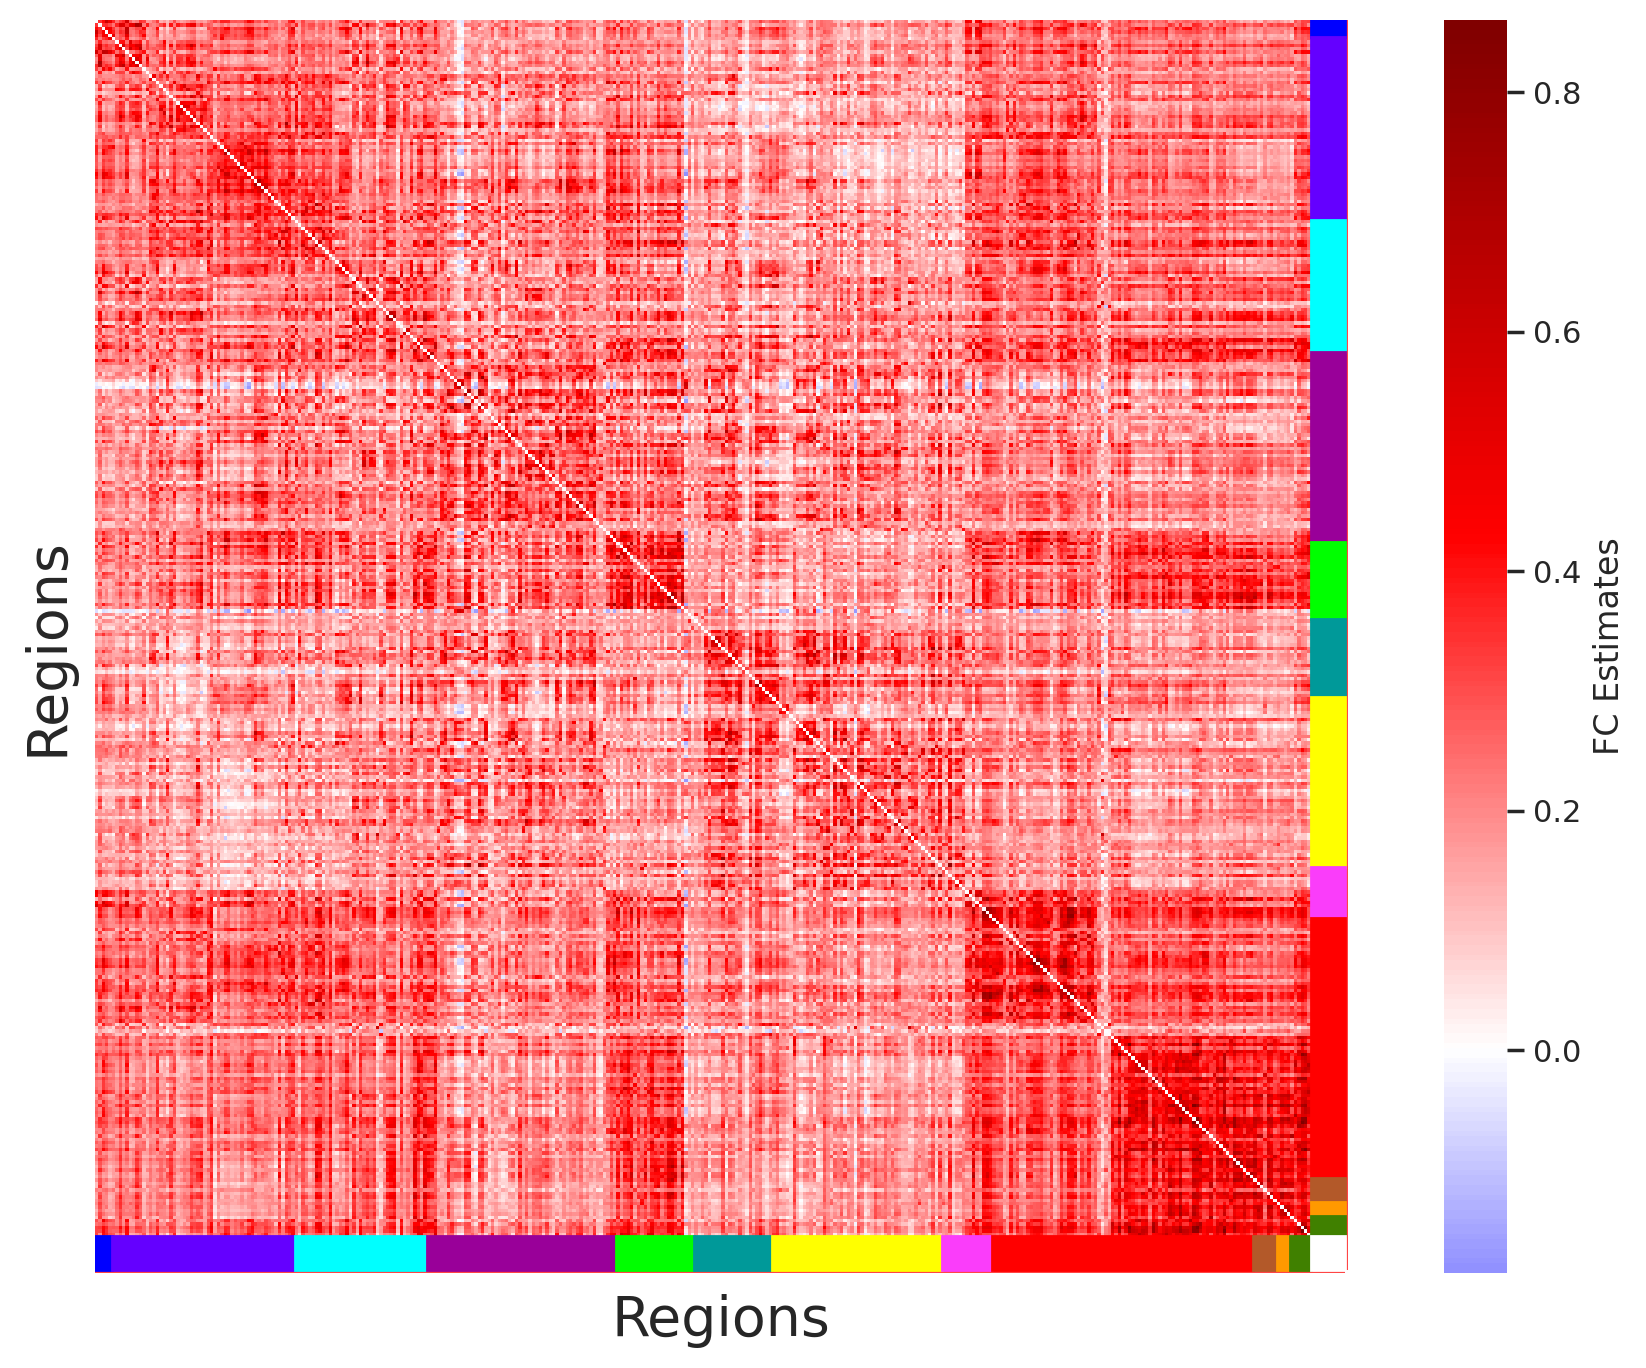

In [14]:
#Visualize FC matrix
netorder = np.argsort(region_info['network'])
fcmat=np.mean(restFC_corr[netorder,:,:][:,netorder,:],axis=2)
fig=actflow.tools.addNetColors_Seaborn(fcmat)

In [15]:
#Visualize predicted and actual activation patterns
taskConditions = []
for experiment in EXPERIMENTS.keys():
    for condition in EXPERIMENTS[experiment]['cond']:
        taskConditions.append(f"{experiment.lower()}_{condition}")

plt.figure(figsize=[7,5])
ax = sns.heatmap(np.mean(actflowOutput_restFCCorr_bycond['actPredVector_bytask_bysubj'],axis=2)[netorder,:],center=0,cmap='seismic',cbar=True,yticklabels=100,xticklabels=taskConditions)
ax.figure.suptitle('Predicted activations, corr FC actflow')
ax.set(ylabel='Regions')

plt.figure(figsize=[7,5])
ax = sns.heatmap(np.mean(activations_bycond,axis=2)[netorder,:],center=0,cmap='seismic',cbar=True,yticklabels=100,xticklabels=taskConditions)
ax.figure.suptitle('Actual activations (24 conditions)')
ax.set(ylabel='Regions')


NameError: name 'actflowOutput_restFCCorr_bycond' is not defined

<Figure size 700x500 with 0 Axes>

In [16]:
taskConditions[22]

'social_mental'

In [17]:
#Plotting brain surface images in-line, FC-based predictions

condNum=22 #condition = relational reasoning

#RestFC predicted
inputdata=np.mean(actflowOutput_restFCCorr_bycond['actPredVector_bytask_bysubj'],axis=2)[:,condNum]
print('Min value: ', np.min(inputdata))
print('Max value: ', np.max(inputdata))
#flip hemispheres, since CAB-NP is ordered left-to-right, while wbplot uses right-to-left
inputdata_flipped=np.zeros(np.shape(inputdata))
inputdata_flipped[0:180]=inputdata[180:360]
inputdata_flipped[180:360]=inputdata[0:180]
file_out="out.png"
#Set to all reds if no negative values
if min(inputdata) >= 0:
    colormap='Reds'
else:
    colormap='seismic'
pscalar(
        file_out=file_out,
        pscalars=inputdata_flipped,
        cmap=colormap,
        transparent=True)
img = mpimg.imread(file_out)
plt.figure()
plt.axis('off')
plt.title('Corr. restFC actflow predictions (social mental)')
plt.imshow(img)

#Actual activity
inputdata=np.mean(activations_bycond,axis=2)[:,condNum]
print('Min value: ', np.min(inputdata))
print('Max value: ', np.max(inputdata))
#flip hemispheres, since CAB-NP is ordered left-to-right, while wbplot uses right-to-left
inputdata_flipped=np.zeros(np.shape(inputdata))
inputdata_flipped[0:180]=inputdata[180:360]
inputdata_flipped[180:360]=inputdata[0:180]
file_out="out.png"
#Set to all reds if no negative values
if min(inputdata) >= 0:
    colormap='Reds'
#Plotting brain surface images in-line, FC-based predictions

condNum=22 #condition = relational reasoning

#RestFC predicted
inputdata=np.mean(actflowOutput_restFCCorr_bycond['actPredVector_bytask_bysubj'],axis=2)[:,condNum]
print('Min value: ', np.min(inputdata))
print('Max value: ', np.max(inputdata))
#flip hemispheres, since CAB-NP is ordered left-to-right, while wbplot uses right-to-left
inputdata_flipped=np.zeros(np.shape(inputdata))
inputdata_flipped[0:180]=inputdata[180:360]
inputdata_flipped[180:360]=inputdata[0:180]
file_out="out.png"
#Set to all reds if no negative values
if min(inputdata) >= 0:
    colormap='Reds'
else:
    colormap='seismic'
pscalar(
        file_out=file_out,
        pscalars=inputdata_flipped,
        cmap=colormap,
        transparent=True)
img = mpimg.imread(file_out)
plt.figure()
plt.axis('off')
plt.title('Corr. restFC actflow predictions (social mental)')
plt.imshow(img)

#Actual activity
inputdata=np.mean(activations_bycond,axis=2)[:,condNum]
print('Min value: ', np.min(inputdata))
print('Max value: ', np.max(inputdata))
#flip hemispheres, since CAB-NP is ordered left-to-right, while wbplot uses right-to-left
inputdata_flipped=np.zeros(np.shape(inputdata))
inputdata_flipped[0:180]=inputdata[180:360]
inputdata_flipped[180:360]=inputdata[0:180]
file_out="out.png"
#Set to all reds if no negative values
if min(inputdata) >= 0:
    colormap='Reds'
else:
    colormap='seismic'
pscalar(
        file_out=file_out,
        pscalars=inputdata_flipped,
        cmap=colormap,
        transparent=False)
img = mpimg.imread(file_out)
plt.figure()
plt.axis('off')
plt.title('Actual activations (social mental)')
plt.imshow(img)
condNum=22 #condition = relational reasoning

#RestFC predicted
inputdata=np.mean(actflowOutput_restFCCorr_bycond['actPredVector_bytask_bysubj'],axis=2)[:,condNum]
print('Min value: ', np.min(inputdata))
print('Max value: ', np.max(inputdata))
#flip hemispheres, since CAB-NP is ordered left-to-right, while wbplot uses right-to-left
inputdata_flipped=np.zeros(np.shape(inputdata))
inputdata_flipped[0:180]=inputdata[180:360]
inputdata_flipped[180:360]=inputdata[0:180]
file_out="out.png"
#Set to all reds if no negative values
if min(inputdata) >= 0:
    colormap='Reds'
else:
    colormap='seismic'
pscalar(
        file_out=file_out,
        pscalars=inputdata_flipped,
        cmap=colormap,
        transparent=True)
img = mpimg.imread(file_out)
plt.figure()
plt.axis('off')
plt.title('Corr. restFC actflow predictions (social mental)')
plt.imshow(img)

#Actual activity
inputdata=np.mean(activations_bycond,axis=2)[:,condNum]
print('Min value: ', np.min(inputdata))
print('Max value: ', np.max(inputdata))
#flip hemispheres, since CAB-NP is ordered left-to-right, while wbplot uses right-to-left
inputdata_flipped=np.zeros(np.shape(inputdata))
inputdata_flipped[0:180]=inputdata[180:360]
inputdata_flipped[180:360]=inputdata[0:180]
file_out="out.png"
#Set to all reds if no negative values
if min(inputdata) >= 0:
    colormap='Reds'
else:
    colormap='seismic'
pscalar(
        file_out=file_out,
        pscalars=inputdata_flipped,
        cmap=colormap,
        transparent=False) # removed surf_data, it was causing a syntax error
img = mpimg.imread(file_out)
plt.figure()
plt.axis('off')
plt.title('Actual activations (social mental)')
plt.imshow(img)
img = mpimg.imread(file_out)
plt.figure()
plt.axis('off')
plt.title('Actual activations (social mental)')
plt.imshow(img)



pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Min value:  75.31000501448962
Max value:  899.4366263516831


FileNotFoundError: [Errno 2] No such file or directory: 'out.png'

# Multi-Regression FC

In [19]:
%%time
#Run activity flow mapping

# Define the number of nodes and subjects
numnodes = restdata.shape[0]  # Get the number of nodes from restdata shape
numsubjs = restdata.shape[2]  # Get the number of subjects from restdata shape


#Calculate multiple-regression FC
restFC_mreg=np.zeros((numnodes,numnodes,numsubjs))
for scount in np.arange(numsubjs):
    restFC_mreg[:,:,scount]=actflow.connectivity_estimation.multregconn(restdata[:,:,scount])

CPU times: user 1h 35min 8s, sys: 17 s, total: 1h 35min 25s
Wall time: 54min 52s


In [20]:
print("==Activity flow mapping results, multiple-regression-based resting-state FC, 24 task conditions==")
actflowOutput_restFCMReg_bycond = actflow.actflowcomp.actflowtest(activations_bycond, restFC_mreg)

==Activity flow mapping results, multiple-regression-based resting-state FC, 24 task conditions==
===Comparing prediction accuracies between models (similarity between predicted and actual brain activation patterns)===
 
==Comparisons between predicted and actual activation patterns, across all conditions and nodes:==
--Compare-then-average (calculating prediction accuracies before cross-subject averaging):
Each comparison based on 24 conditions across 360 nodes, p-values based on 100 subjects (cross-subject variance in comparisons)
 
Mean Pearson r = 0.63, t-value vs. 0: 51.74, p-value vs. 0: 1.756057824697668e-73
 
Mean % variance explained (R^2 score, coeff. of determination) = 0.31
 
Mean MAE (mean absolute error) = 12.21
 
Note: Pearson r and Pearson r^2 are scale-invariant, while R^2 and MAE are not. R^2 units: percentage of the to-be-predicted data's unscaled variance, ranging from negative infinity (because prediction errors can be arbitrarily large) to positive 1. See https://

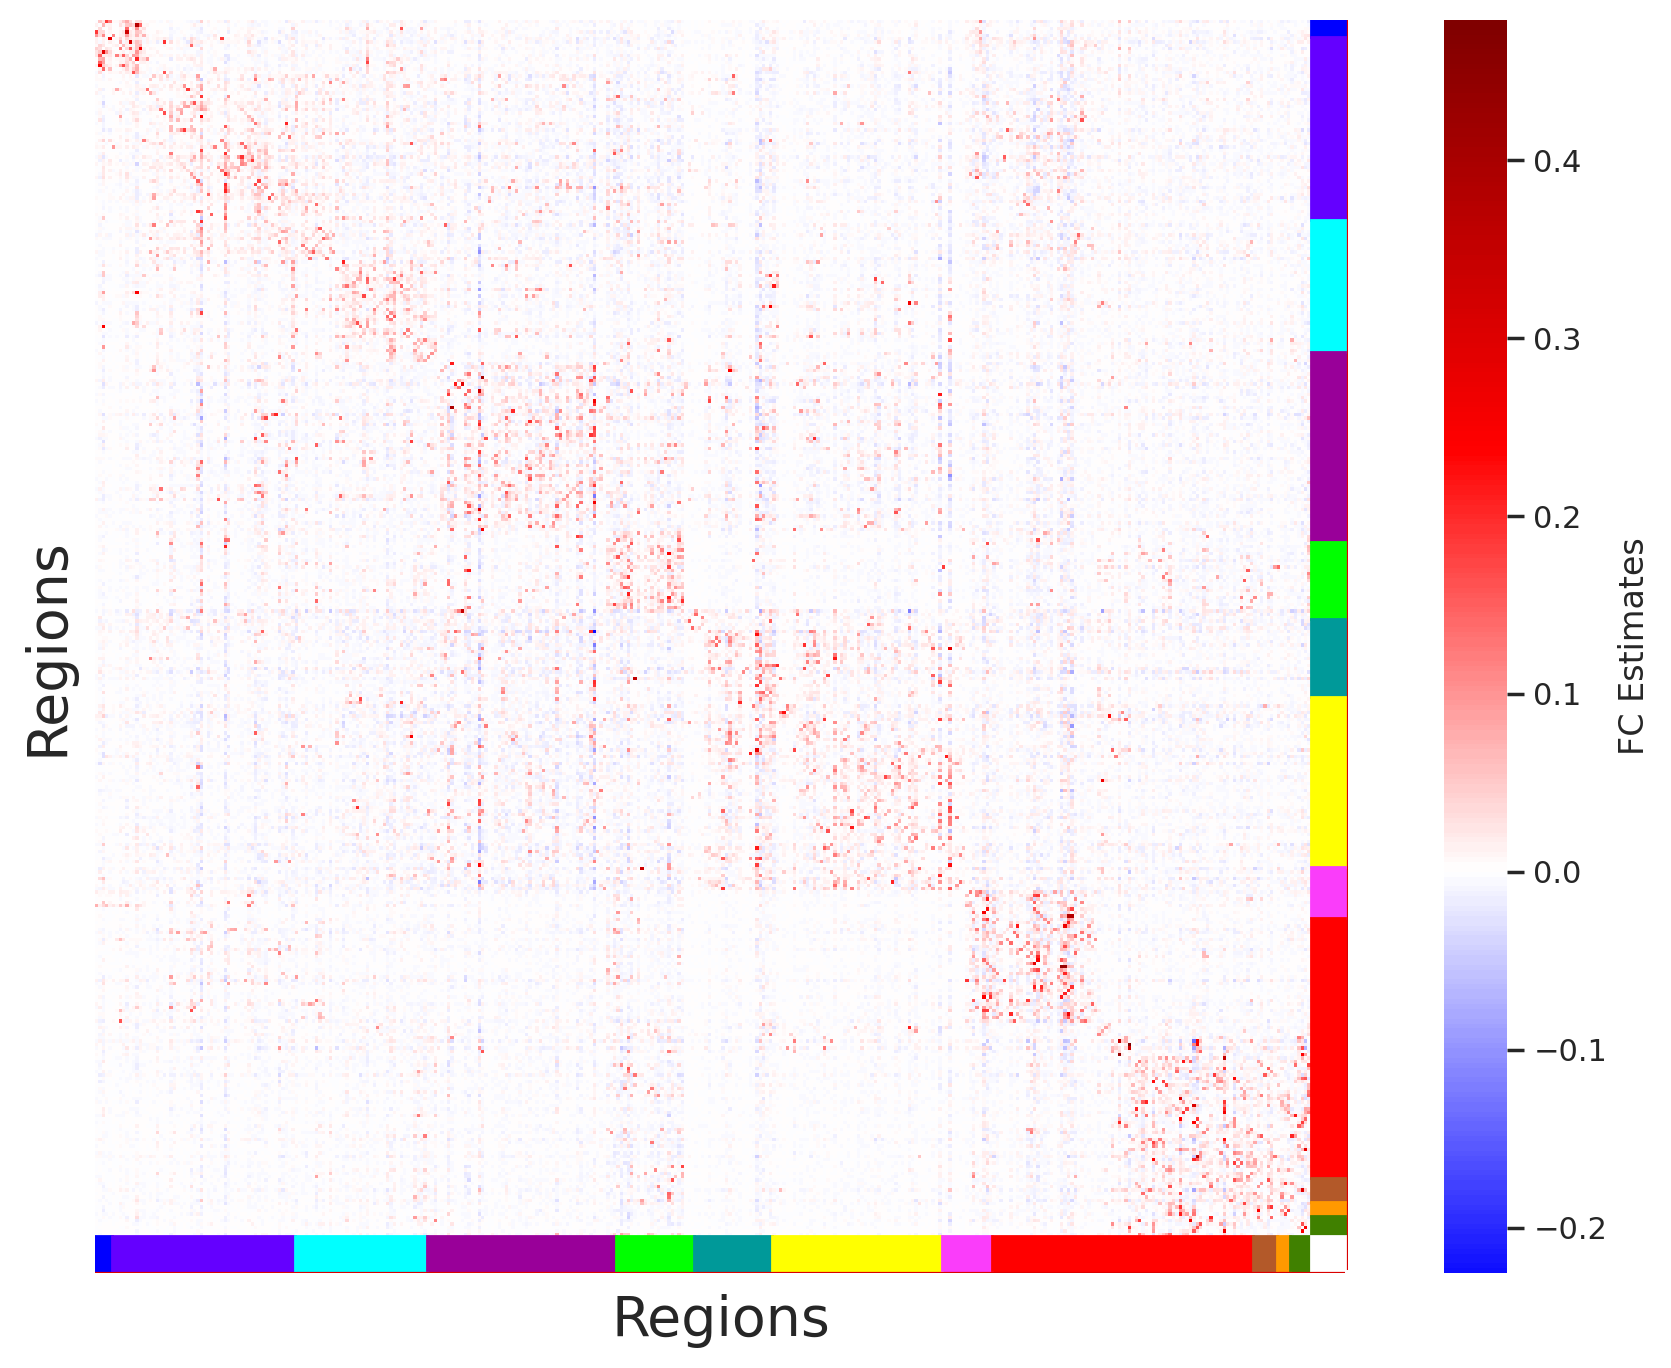

In [21]:
#Visualize multreg FC matrix
fcmat=np.mean(restFC_mreg[netorder,:,:][:,netorder,:],axis=2)
fig=actflow.tools.addNetColors_Seaborn(fcmat)

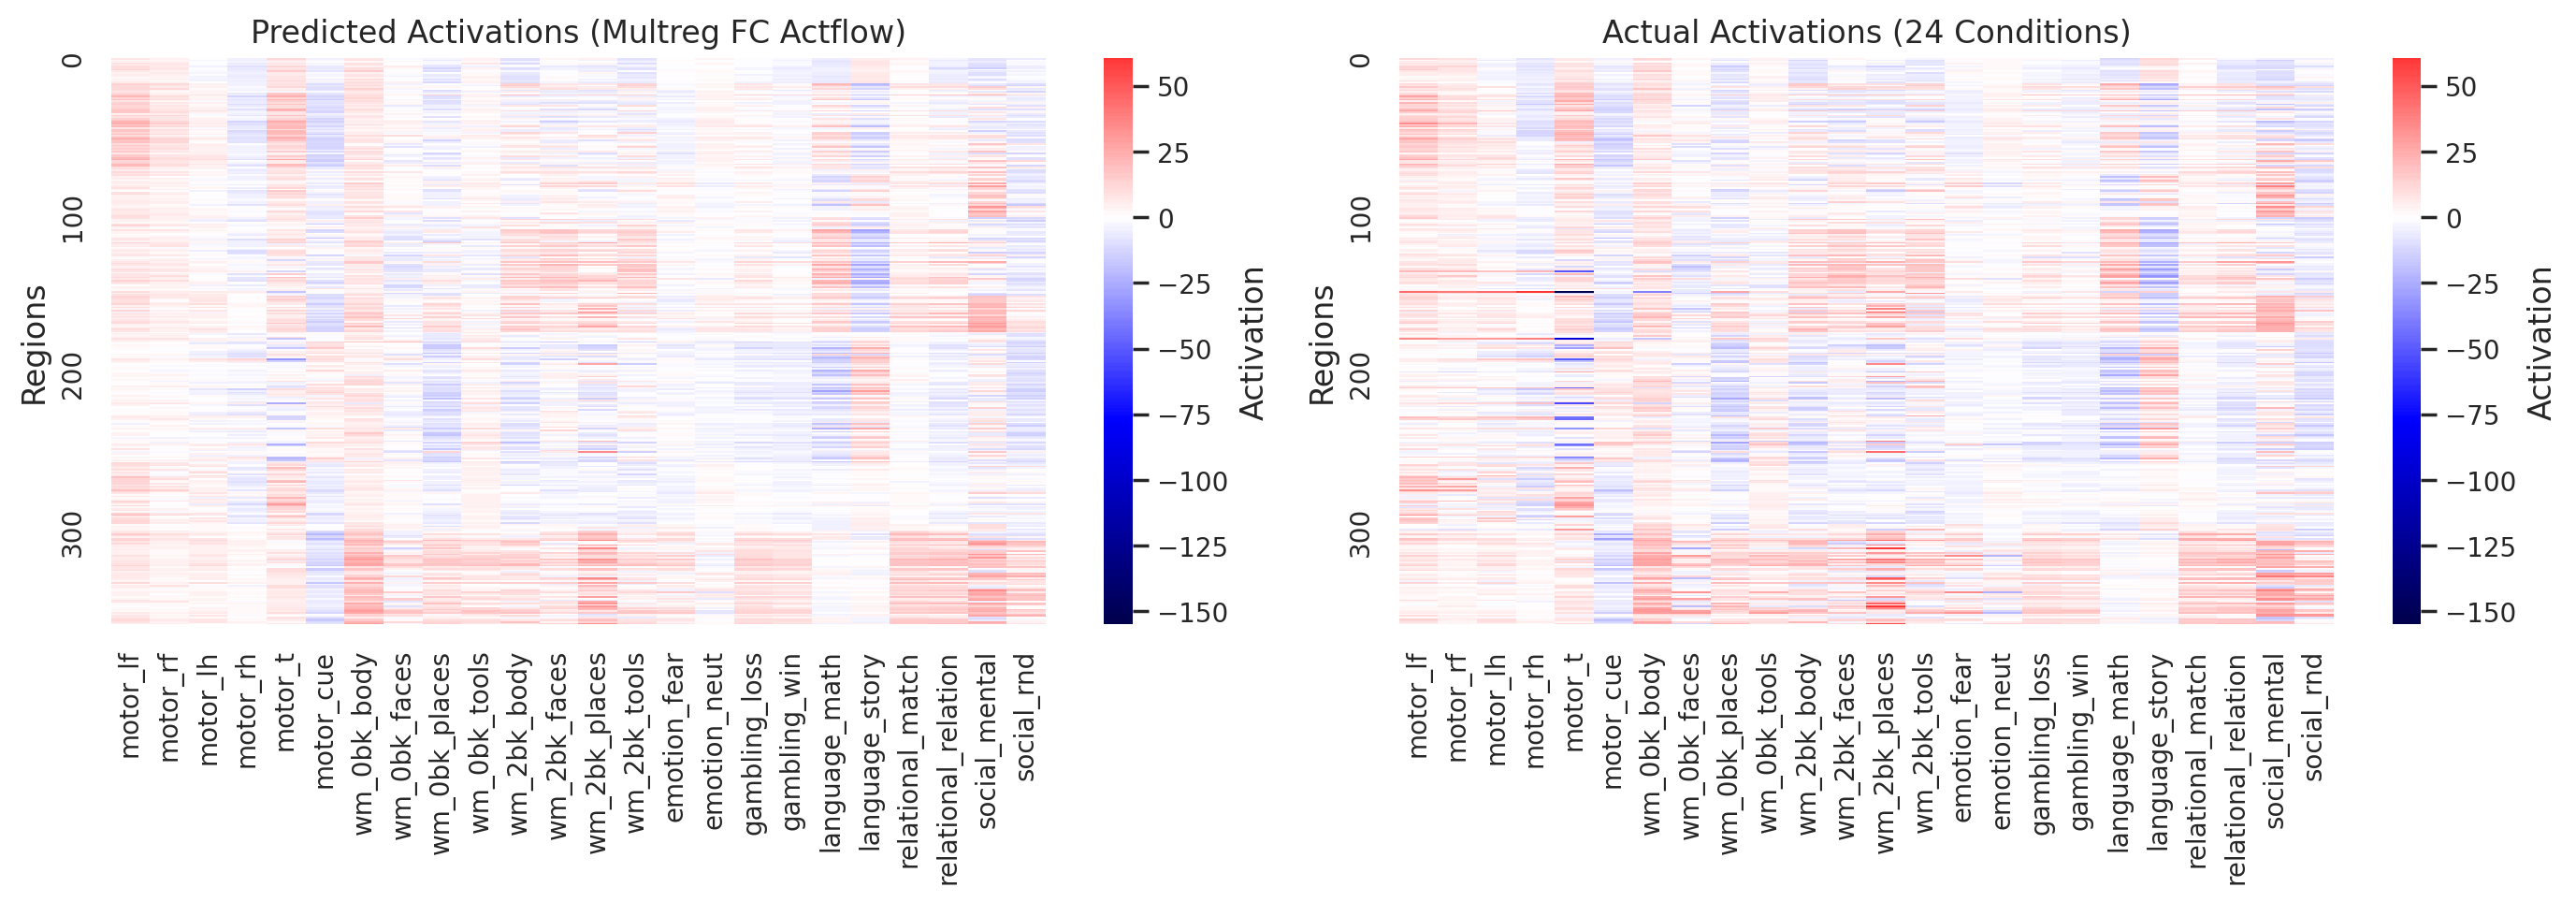

In [24]:
# Calculate and store the mean predicted activations across subjects for each task
predicted_mean = np.mean(actflowOutput_restFCMReg_bycond['actPredVector_bytask_bysubj'], axis=2)[netorder, :]

# Calculate and store the mean actual activations across subjects for each task
actual_mean = np.mean(activations_bycond, axis=2)[netorder, :]

# Compute the global min/max values across both datasets
vmin = min(predicted_mean.min(), actual_mean.min())
vmax = max(predicted_mean.max(), actual_mean.max())

# Create a figure with two subplots (side by side)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot Predicted Activations
sns.heatmap(predicted_mean, center=0, cmap='seismic', ax=axes[0],
            cbar=True, cbar_kws={'label': 'Activation'},
            vmin=vmin, vmax=vmax,  # Set fixed scale
            yticklabels=100, xticklabels=taskConditions)
axes[0].set_title("Predicted Activations (Multreg FC Actflow)")
axes[0].set_ylabel("Regions")

# Plot Actual Activations
sns.heatmap(actual_mean, center=0, cmap='seismic', ax=axes[1],
            cbar=True, cbar_kws={'label': 'Activation'},
            vmin=vmin, vmax=vmax,  # Set fixed scale
            yticklabels=100, xticklabels=taskConditions)
axes[1].set_title("Actual Activations (24 Conditions)")
axes[1].set_ylabel("Regions")

# Adjust layout for better spacing
plt.tight_layout()
plt.show()


In [25]:
pip install --upgrade nilearn


In [26]:
from nilearn.datasets import fetch_surf_fsaverage
fsaverage = fetch_surf_fsaverage()


Predicted Data Shape: (360,)
Actual Data Shape: (360,)
Mapping 360 regions to 10242 vertices...
Total vertices in mapped data: 20484


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


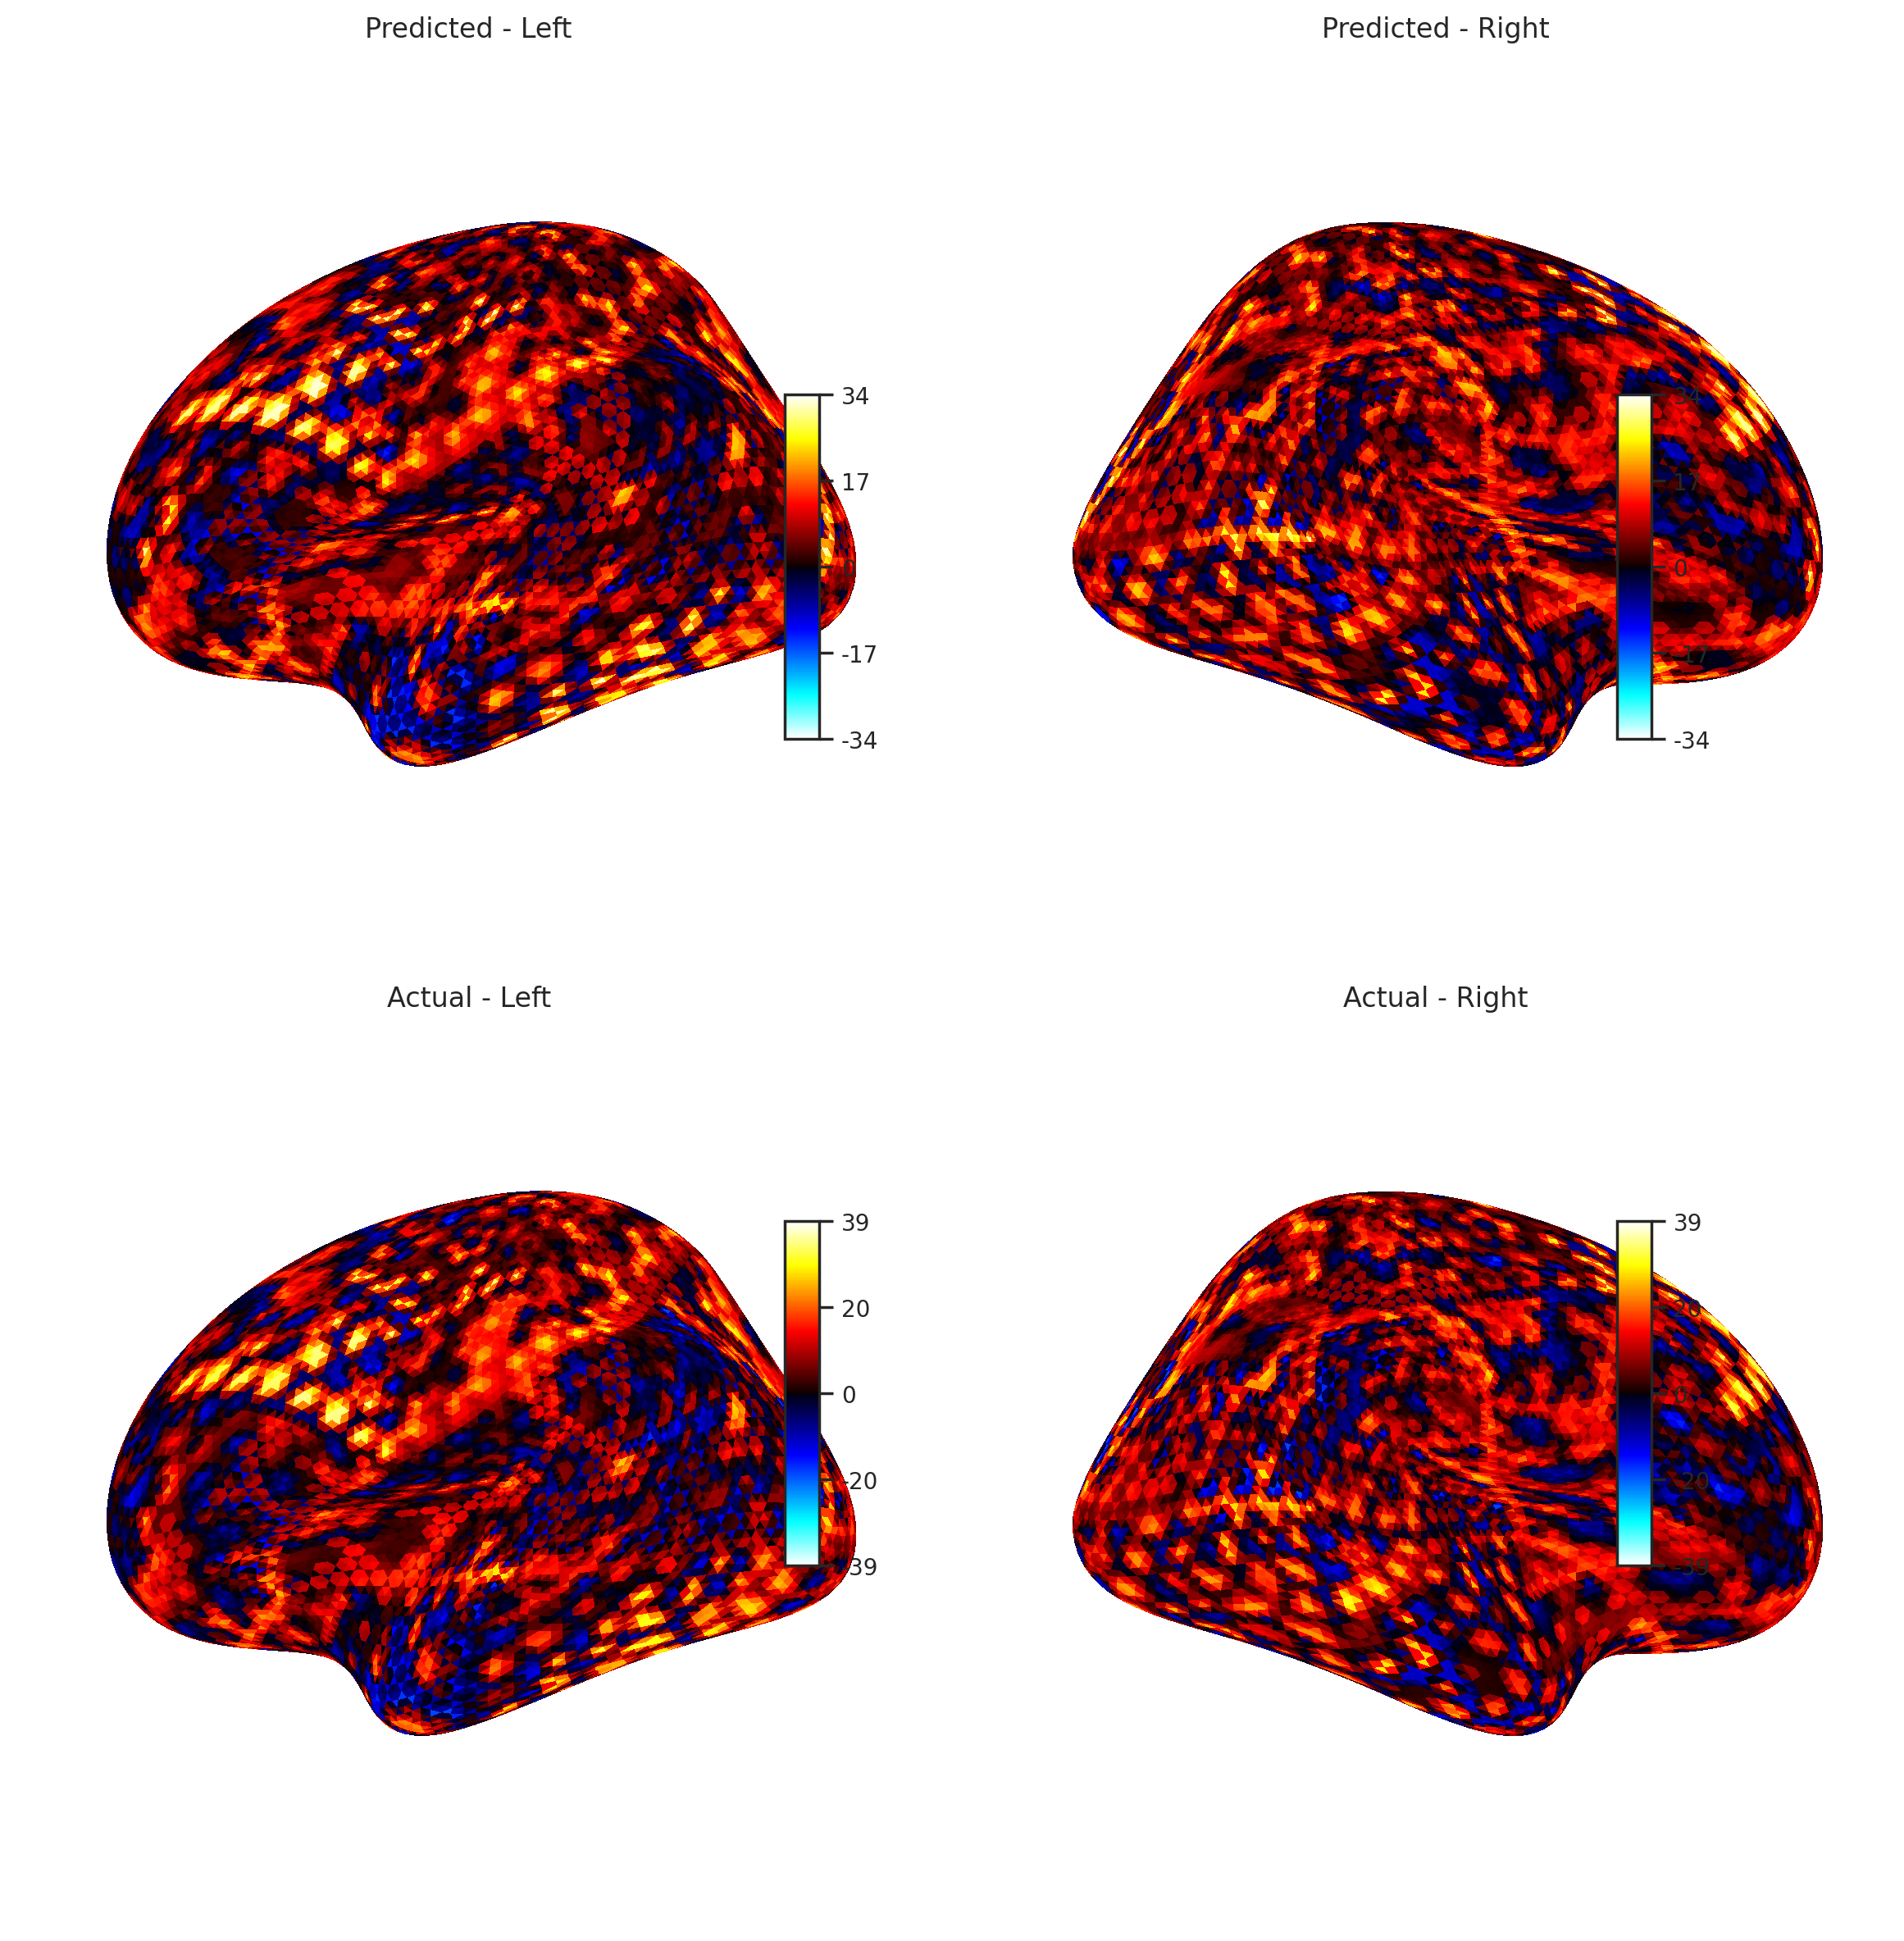

In [27]:
from nilearn import plotting, datasets
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt

# Fetch fsaverage template (including surface meshes)
fsaverage = datasets.fetch_surf_fsaverage()

# Define the condition for the Social Mental Task (condition number 22)
condNum = 22

# Extract Predicted Activations (assuming actflowOutput_restFCMReg_bycond is available)
predicted_data = np.mean(actflowOutput_restFCMReg_bycond['actPredVector_bytask_bysubj'], axis=2)[:, condNum]

# Extract Actual Activations (assuming activations_bycond is available)
actual_data = np.mean(activations_bycond, axis=2)[:, condNum]

# Check if data is valid and has correct size
if predicted_data.size == 0 or actual_data.size == 0:
    print("Error: Activation data is empty. Please check your data.")
else:
    print("Predicted Data Shape:", predicted_data.shape)
    print("Actual Data Shape:", actual_data.shape)

    # Check the length of your activation data and the fsaverage mesh size
    infl_left = fsaverage['infl_left']
    infl_right = fsaverage['infl_right']

    # Load surface meshes using nibabel
    left_mesh = nib.load(infl_left)
    right_mesh = nib.load(infl_right)

    # Access the surface vertices
    left_vertices = left_mesh.darrays[0].data  # The vertices for the left hemisphere
    right_vertices = right_mesh.darrays[0].data  # The vertices for the right hemisphere

    n_vertices = len(left_vertices)  # Each hemisphere should have 10242 vertices

    # Ensure your data is compatible with the number of vertices (10242 per hemisphere)
    if predicted_data.shape[0] != n_vertices:
        print(f"Mapping {predicted_data.shape[0]} regions to {n_vertices} vertices...")

        # Interpolation (adjust based on how your data is structured)
        mapped_predicted = np.interp(np.linspace(0, 1, n_vertices), np.linspace(0, 1, len(predicted_data)), predicted_data)
        mapped_actual = np.interp(np.linspace(0, 1, n_vertices), np.linspace(0, 1, len(actual_data)), actual_data)
    else:
        # If the data is already the correct shape, no need for interpolation
        mapped_predicted = predicted_data
        mapped_actual = actual_data

    # Now, we need to duplicate data to fill both hemispheres
    mapped_predicted_full = np.concatenate([mapped_predicted, mapped_predicted])  # Repeat for both hemispheres
    mapped_actual_full = np.concatenate([mapped_actual, mapped_actual])  # Repeat for both hemispheres

    # Check if the final mapped data is valid
    if mapped_predicted_full.size == 0 or mapped_actual_full.size == 0:
        print("Error: Mapped activation data is empty. Please check the data.")
    else:
        # Check that the total number of vertices is correctly matched
        total_vertices = len(mapped_predicted_full)  # should be 2 * n_vertices
        print(f"Total vertices in mapped data: {total_vertices}")

        # Ensure that mapped data is split correctly into left and right hemispheres
        if total_vertices != 2 * n_vertices:
            print(f"Warning: Mapped data size {total_vertices} does not match expected size {2 * n_vertices}.")
        else:
            # Create the surface plots side-by-side (without using axes)
            fig = plt.figure(figsize=(12, 12))  # Create a single figure for the 2x2 grid

            # Plot Predicted Activations (Left Hemisphere)
            ax1 = fig.add_subplot(2, 2, 1, projection='3d')
            plotting.plot_surf_stat_map(fsaverage['infl_left'], mapped_predicted_full[:n_vertices], hemi='left',
                                        title="Predicted - Left", colorbar=True, figure=fig, axes=ax1)

            # Plot Predicted Activations (Right Hemisphere)
            ax2 = fig.add_subplot(2, 2, 2, projection='3d')
            plotting.plot_surf_stat_map(fsaverage['infl_right'], mapped_predicted_full[n_vertices:], hemi='right',
                                        title="Predicted - Right", colorbar=True, figure=fig, axes=ax2)

            # Plot Actual Activations (Left Hemisphere)
            ax3 = fig.add_subplot(2, 2, 3, projection='3d')
            plotting.plot_surf_stat_map(fsaverage['infl_left'], mapped_actual_full[:n_vertices], hemi='left',
                                        title="Actual - Left", colorbar=True, figure=fig, axes=ax3)

            # Plot Actual Activations (Right Hemisphere)
            ax4 = fig.add_subplot(2, 2, 4, projection='3d')
            plotting.plot_surf_stat_map(fsaverage['infl_right'], mapped_actual_full[n_vertices:], hemi='right',
                                        title="Actual - Right", colorbar=True, figure=fig, axes=ax4)

            # Adjust the layout manually
            plt.subplots_adjust(hspace=0.4, wspace=0.4)  # Manually adjust spacing between subplots
            plt.show()


# ABIDE Dataset

In [ ]:
# Main collect and download function
def collect_and_download(derivative, pipeline, strategy, out_dir, diagnosis):
    import os
    import urllib.request as request

    # Init variables
    mean_fd_thresh = 0.2
    s3_prefix = 'https://s3.amazonaws.com/fcp-indi/data/Projects/ABIDE_Initiative'
    s3_pheno_path = '/'.join([s3_prefix, 'Phenotypic_V1_0b_preprocessed1.csv'])

    derivative = derivative.lower()
    pipeline = pipeline.lower()
    strategy = strategy.lower()

    # Check derivative for extension
    if 'roi' in derivative:
        extension = '.1D'
    else:
        extension = '.nii.gz'

    if not os.path.exists(out_dir):
        print('Could not find {0}, creating now...'.format(out_dir))
        os.makedirs(out_dir)

    s3_pheno_file = request.urlopen(s3_pheno_path)
    pheno_list = s3_pheno_file.readlines()

    header = pheno_list[0].decode().split(',')
    try:
        site_idx = header.index('SITE_ID')
        file_idx = header.index('FILE_ID')
        age_idx = header.index('AGE_AT_SCAN')
        sex_idx = header.index('SEX')
        dx_idx = header.index('DX_GROUP')
        mean_fd_idx = header.index('func_mean_fd')
    except Exception as exc:
        err_msg = 'Unable to extract header information from the pheno file...'
        raise Exception(err_msg)

    s3_paths = []
    for pheno_row in pheno_list[1:]:
        cs_row = pheno_row.decode().split(',')

        try:
            row_file_id = cs_row[file_idx]
            row_site = cs_row[site_idx]
            row_age = float(cs_row[age_idx])
            row_sex = cs_row[sex_idx]
            row_dx = cs_row[dx_idx]
            row_mean_fd = float(cs_row[mean_fd_idx])
        except Exception as e:
            continue

        if row_file_id == 'no_filename':
            continue
        if row_mean_fd >= mean_fd_thresh:
            continue

        if (diagnosis == 'asd' and row_dx != '1') or (diagnosis == 'tdc' and row_dx != '2'):
            continue

        filename = row_file_id + '_' + derivative + extension
        s3_path = '/'.join([s3_prefix, 'Outputs', pipeline, strategy, derivative, filename])
        s3_paths.append(s3_path)

    total_num_files = len(s3_paths)
    for path_idx, s3_path in enumerate(s3_paths):
        rel_path = s3_path.lstrip(s3_prefix)
        download_file = os.path.join(out_dir, rel_path)
        download_dir = os.path.dirname(download_file)
        if not os.path.exists(download_dir):
            os.makedirs(download_dir)
        try:
            if not os.path.exists(download_file):
                print('Retrieving: {0}'.format(download_file))
                request.urlretrieve(s3_path, download_file)
                print('{0:.3f}% percent complete'.format(100*(float(path_idx+1)/total_num_files)))
            else:
                print('File {0} already exists, skipping...'.format(download_file))
        except Exception as exc:
            print('There was a problem downloading {0}.\n Check input arguments and try again.'.format(s3_path))

    print('Done!')

# pipelines = ["ccs", "cpac", "dparsf", "niak"]
# strategies = ["filt_global", "filt_noglobal", "nofilt_global", "nofilt_noglobal"]
# derivatives = ["alff", "degree_binarize", "degree_weighted", "dual_regression", "eigenvector_binarize", "eigenvector_weighted", "falff", "func_mask", "func_mean", "func_preproc", "lfcd", "reho", "rois_aal", "rois_cc200", "rois_cc400", "rois_dosenbach160", "rois_ez", "rois_ho", "rois_tt", "vmhc"]
# extensions = ["1D", "nii.gz"]

# Variables to specify download settings (modify these values as needed)
desired_derivative = 'rois_cc200'  # Derivative of interest (e.g. 'reho')
desired_pipeline = 'cpac'     # Pipeline used to preprocess the data (e.g. 'cpac')
desired_strategy = 'filt_global'  # Noise-removal strategy used during preprocessing
download_data_dir = 'preprocessed_dataset'  # Path to local folder to download files to
desired_diagnosis = 'both'  # 'asd', 'tdc', or 'both' corresponding to the diagnosis of the participants for whom data should be downloaded

# Call the collect and download routine
collect_and_download(desired_derivative, desired_pipeline, desired_strategy, download_data_dir, desired_diagnosis)

In [29]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
download_data_dir = '/content/drive/MyDrive/preprocessed_dataset'


In [ ]:
import os
import numpy as np
import pandas as pd

# Directory containing the .1D files (replace with your path)
data_dir = '/content/drive/MyDrive/preprocessed_dataset/'

import glob

# Define the path to the subject data files
data_files = glob.glob('/content/drive/MyDrive/preprocessed_dataset/dataset.zip/Outputs/cpac/filt_global/rois_cc200')  # Assuming 1D files for each subject


In [ ]:
import numpy as np

# Define the path to a sample subject file (assuming it's the same format for all subjects)
sample_file = '/content/drive/MyDrive/preprocessed_dataset/dataset.zip/Outputs/cpac/filt_global/rois_cc200/KKI_0050788_rois_cc200.1D'

# Load the data from the file
data = np.loadtxt(sample_file)

# Calculate the number of ROIs and number of time points
num_rois = data.shape[0]  # Number of rows = number of ROIs
num_time_points = data.shape[1]  # Number of columns = number of time points

print(f"Number of ROIs: {num_rois}")
print(f"Number of Time Points: {num_time_points}")


Number of ROIs: 152
Number of Time Points: 200


In [ ]:
import numpy as np
import glob

# List of files in the directory
data_files = glob.glob('/content/drive/MyDrive/preprocessed_dataset/dataset.zip/Outputs/cpac/filt_global/rois_cc200/*.1D')  # List of files

# Initialize variables to calculate the sum of ROIs and time points
total_rois = 0
total_time_points = 0
num_files = len(data_files)

# Iterate over all files to calculate the number of ROIs and time points
for file in data_files:
    data = np.loadtxt(file)
    num_rois, num_time_points = data.shape  # Get the dimensions of the data

    total_rois += num_rois
    total_time_points += num_time_points

# Calculate the average number of ROIs and time points
average_rois = total_rois / num_files
average_time_points = total_time_points / num_files

print(f"Average number of ROIs: {average_rois}")
print(f"Average number of time points: {average_time_points}")


Average number of ROIs: 192.2002262443439
Average number of time points: 200.0


In [35]:
import numpy as np
from scipy.interpolate import interp1d
import glob
import os

# Function to interpolate time series data
def interpolate_time_series(data, new_time_points, target_rois):
    """Interpolates the time series data to match the target number of ROIs and time points."""

    # Ensure data is at least 2D
    if data.ndim == 1:
        data = data.reshape(1, -1)  # Reshape to (1, num_time_points)

    num_rois, num_time_points = data.shape  # Get dimensions after reshaping

    # Adjust ROI count
    if num_rois < target_rois:
        padding = target_rois - num_rois
        data = np.pad(data, ((0, padding), (0, 0)), mode='constant')  # Pad with zeros
    elif num_rois > target_rois:
        data = data[:target_rois, :]  # Truncate

    # Generate the original time points
    original_time_points = np.arange(num_time_points)

    # Generate new interpolated time points
    new_time_points = np.linspace(0, num_time_points - 1, new_time_points).astype(int)

    # Interpolate data for each ROI
    interpolated_data = np.zeros((target_rois, new_time_points.size))
    for roi_idx in range(target_rois):
        f = interp1d(original_time_points, data[roi_idx, :], kind='linear', fill_value='extrapolate')
        interpolated_data[roi_idx, :] = f(new_time_points)

    return interpolated_data

# Define input and output folder paths
input_folder = "/content/drive/MyDrive/preprocessed_dataset/dataset.zip/Outputs/cpac/filt_global/rois_cc200/"
output_folder = "/content/drive/MyDrive/preprocessed_dataset/interpolated_data/"

# Create output folder if it doesn't exist
os.makedirs(output_folder, exist_ok=True)

# Define file pattern and read files
data_files = glob.glob(os.path.join(input_folder, "*.1D"))  # List of .1D files

# Define the correct number of ROIs and time points
num_rois = 200  # Ensure 200 ROIs
num_time_points = 200  # Keep time points consistent
num_subjects = len(data_files)

# Initialize 3D matrix to hold the resting state data (ROIs x time_points x subjects)
restdata = np.zeros((num_rois, num_time_points, num_subjects))

# Loop through each subject file and process it
for i, file in enumerate(data_files):
    subj_data = np.loadtxt(file)  # Load the 1D file data

    # Ensure the shape is correct
    if subj_data.shape[0] != num_rois or subj_data.shape[1] != num_time_points:
        subj_data = interpolate_time_series(subj_data, num_time_points, num_rois)

    # Assign the processed data to the resting state matrix
    restdata[:, :, i] = subj_data.T  # Transpose if necessary to fit shape (ROIs, time_points)

    # Save each subject's interpolated data as a .npy file
    subj_filename = os.path.basename(file).replace(".1D", ".npy")  # Convert file extension
    np.save(os.path.join(output_folder, subj_filename), subj_data)

# Save the full 3D matrix as well
np.save(os.path.join(output_folder, "restdata.npy"), restdata)

# Check the final shape of the resting state data
print("Resting state data saved with shape:", restdata.shape)  # Expected: (200, 200, num_subjects)


Resting state data saved with shape: (200, 200, 884)


In [39]:
import numpy as np
import glob

# Define the path to the subject data files
data_files = glob.glob('/path/to/preprocessed_data/interpolated_data/*.1D')  # Assuming 1D files for each subject

# Initialize the resting state data array
# Assuming each subject's file has time series for each ROI, and you know the number of ROIs and time points
num_rois = 192  # Number of ROIs (change as per your dataset)
num_time_points = 200  # Example, replace with actual time points
num_subjects = len(data_files)

# Initialize 3D matrix to hold the resting data
restdata = np.zeros((num_rois, num_time_points, num_subjects))

# Loop through each subject file and load the data into the restdata matrix
for i, file in enumerate(data_files):
    subj_data = np.loadtxt(file)  # Load the 1D file data
    restdata[:, :, i] = subj_data.T  # Transpose if necessary to fit shape (ROIs, time_points)

print("Resting state data loaded with shape:", restdata.shape)


Resting state data loaded with shape: (192, 200, 0)


#Actflow on ABIDE

In [40]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Load ABIDE data

In [104]:
import numpy as np
import os
import glob

# Parameters
N_ROIS = 200  # Adjust based on your dataset
N_TIMEPOINTS = 200  # Adjust based on your dataset
N_SUBJECTS = 884  # Adjust based on your dataset

# Directory containing preprocessed `.npy` files (adjust the path)
abide_data_dir = '/content/drive/MyDrive/preprocessed_dataset/interpolated_data'

# Get a list of all .npy files in the directory (assuming filenames contain subject identifiers)
file_paths = glob.glob(os.path.join(abide_data_dir, '*.npy'))

# Print number of files found
print(f"Found {len(file_paths)} .npy files")

# Initialize a list to store data for each subject
restdata_list = []

# Load each .npy file and append to the list
for file_path in file_paths:
    try:
        # Load the data from the .npy file
        data = np.load(file_path)

        # Ensure that the data has the expected shape (200 ROIs, 200 timepoints)
        if data.shape != (N_ROIS, N_TIMEPOINTS):
            print(f"Warning: Skipping {file_path}, unexpected shape {data.shape}")
            continue

        restdata_list.append(data)  # Append data to list

    except Exception as e:
        print(f"Error loading file {file_path}: {e}")

# Stack all the subjects' data into a single 3D array (ROIs x Timepoints x Subjects)
if restdata_list:
    restdata = np.stack(restdata_list, axis=2)  # Stack along the third axis (subjects)
    print(f"Restdata Shape: {restdata.shape}")  # Expected shape: (200, 200, 100) for 100 subjects
else:
    print("No valid .npy files were loaded.")



Found 885 .npy files
Restdata Shape: (200, 200, 884)


In [105]:
%%time

# Number of subjects and nodes
numnodes = restdata.shape[0]  # Number of ROIs (200)
numsubjs = restdata.shape[2]  # Number of subjects (884)

# Preallocate the resting-state FC matrix using multiple regression
restFC_mreg = np.zeros((numnodes, numnodes, numsubjs))  # Empty matrix for FC

# Apply multiple regression FC for each subject
for subj_idx in range(numsubjs):
    try:
        restFC_mreg[:, :, subj_idx] = actflow.connectivity_estimation.multregconn(restdata[:, :, subj_idx])
    except Exception as e:
        print(f"Error at subject {subj_idx}: {e}")

# Verify the shape of the resting-state functional connectivity matrix
print("RestFC_mreg shape:", restFC_mreg.shape)  # Should be (200, 200, 884)


KeyboardInterrupt: 

In [106]:
print("==Activity flow mapping results, multiple-regression-based resting-state FC, no task conditions==")

# Create a dummy array for activations with the correct shape (N_ROIS, 1, N_SUBJECTS)
dummy_activation = np.zeros((N_ROIS, 1, N_SUBJECTS))  # Placeholder for activations

# Call actflowtest with both the dummy activation array and resting-state FC matrix
try:
    actflowOutput_restFCMReg = actflow.actflowcomp.actflowtest(
        dummy_activation, restFC_mreg  # Resting-state FC passed as the second argument
    )
    print("Activity Flow Mapping output shape:", actflowOutput_restFCMReg.shape)
except Exception as e:
    print(f"Error during activity flow mapping: {e}")


==Activity flow mapping results, multiple-regression-based resting-state FC, no task conditions==
===Comparing prediction accuracies between models (similarity between predicted and actual brain activation patterns)===


/usr/local/lib/python3.11/dist-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]


 
==Comparisons between predicted and actual activation patterns, across all conditions and nodes:==
--Compare-then-average (calculating prediction accuracies before cross-subject averaging):
Each comparison based on 1 conditions across 200 nodes, p-values based on 884 subjects (cross-subject variance in comparisons)
 
Error during activity flow mapping: output array is read-only


/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [107]:
print(netorder)  # Ensure that all elements are <= 199


[123 102 103  23 172 106 174 173 177 178 189 168 166 179 146 190 112 108
 107 105 104  98  85 147 113  83  77  37  43  56  59  44  36  42  58   9
  57 191 128 127  80 124  78  11 171  25  24  27 138 122  73  74 140 139
  26 193 132 194 143 144 148  14 170  62  28  72  76  79  81  82 169  84
  90 110  97  96  91  88  13 115 116  95 126  94 135 136  10 142 145  45
  49 111 165 109  29  61  30  31 118  68 164  70  71  75  34 117  67  86
  89  92  93 129 176 175 160 161  87  66  69  33 130 131 133 125  65  60
 150 154 119 149 163  64  63  32  46  50  51  52  53  54 114  38 167  55
 188 187   7   8  41  40  99 100  35  39 101 121 134 120   0 141 180 186
 192 195 196 197 137   6 199   5   4   3   2   1 198 185 151 152  12  15
  16  17  47  48  18 155 156 157 158 159 162  19  20  21  22 181 182 183
 184 153]


In [108]:
print("restFC_mreg shape:", restFC_mreg.shape)
print("netorder shape:", netorder.shape)
print("Subset shape:", restFC_mreg[netorder, :, :].shape)
print("Final fcmat shape:", fcmat.shape)


restFC_mreg shape: (200, 200, 884)
netorder shape: (200,)
Subset shape: (200, 200, 884)
Final fcmat shape: (200, 200)


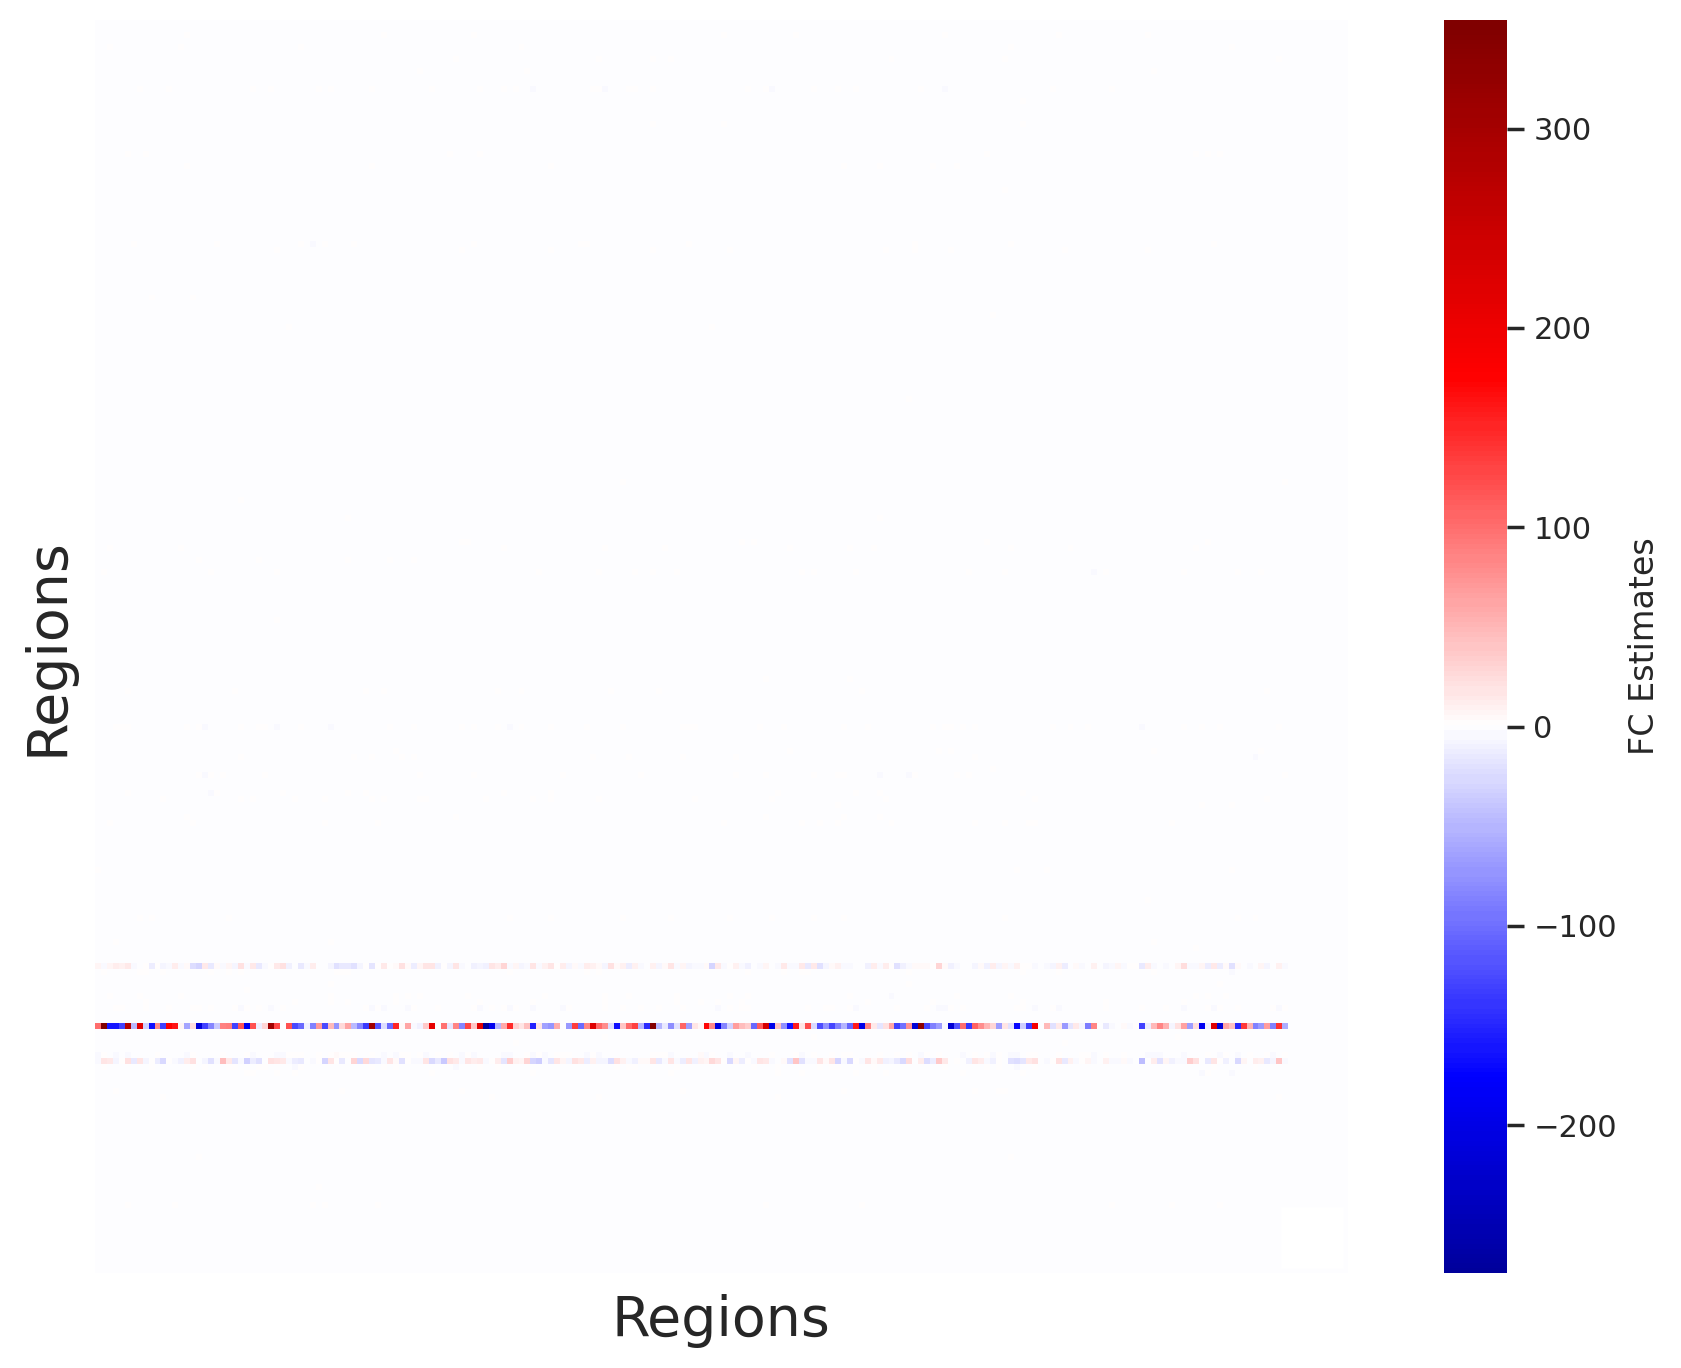

In [109]:
# Ensure netorder is within valid range
netorder = netorder[netorder < 200]

# Now calculate the mean connectivity matrix using valid netorder
fcmat = np.mean(restFC_mreg[netorder, :, :][:, netorder, :], axis=2)

# Visualize the result
fig = actflow.tools.addNetColors_Seaborn(fcmat)


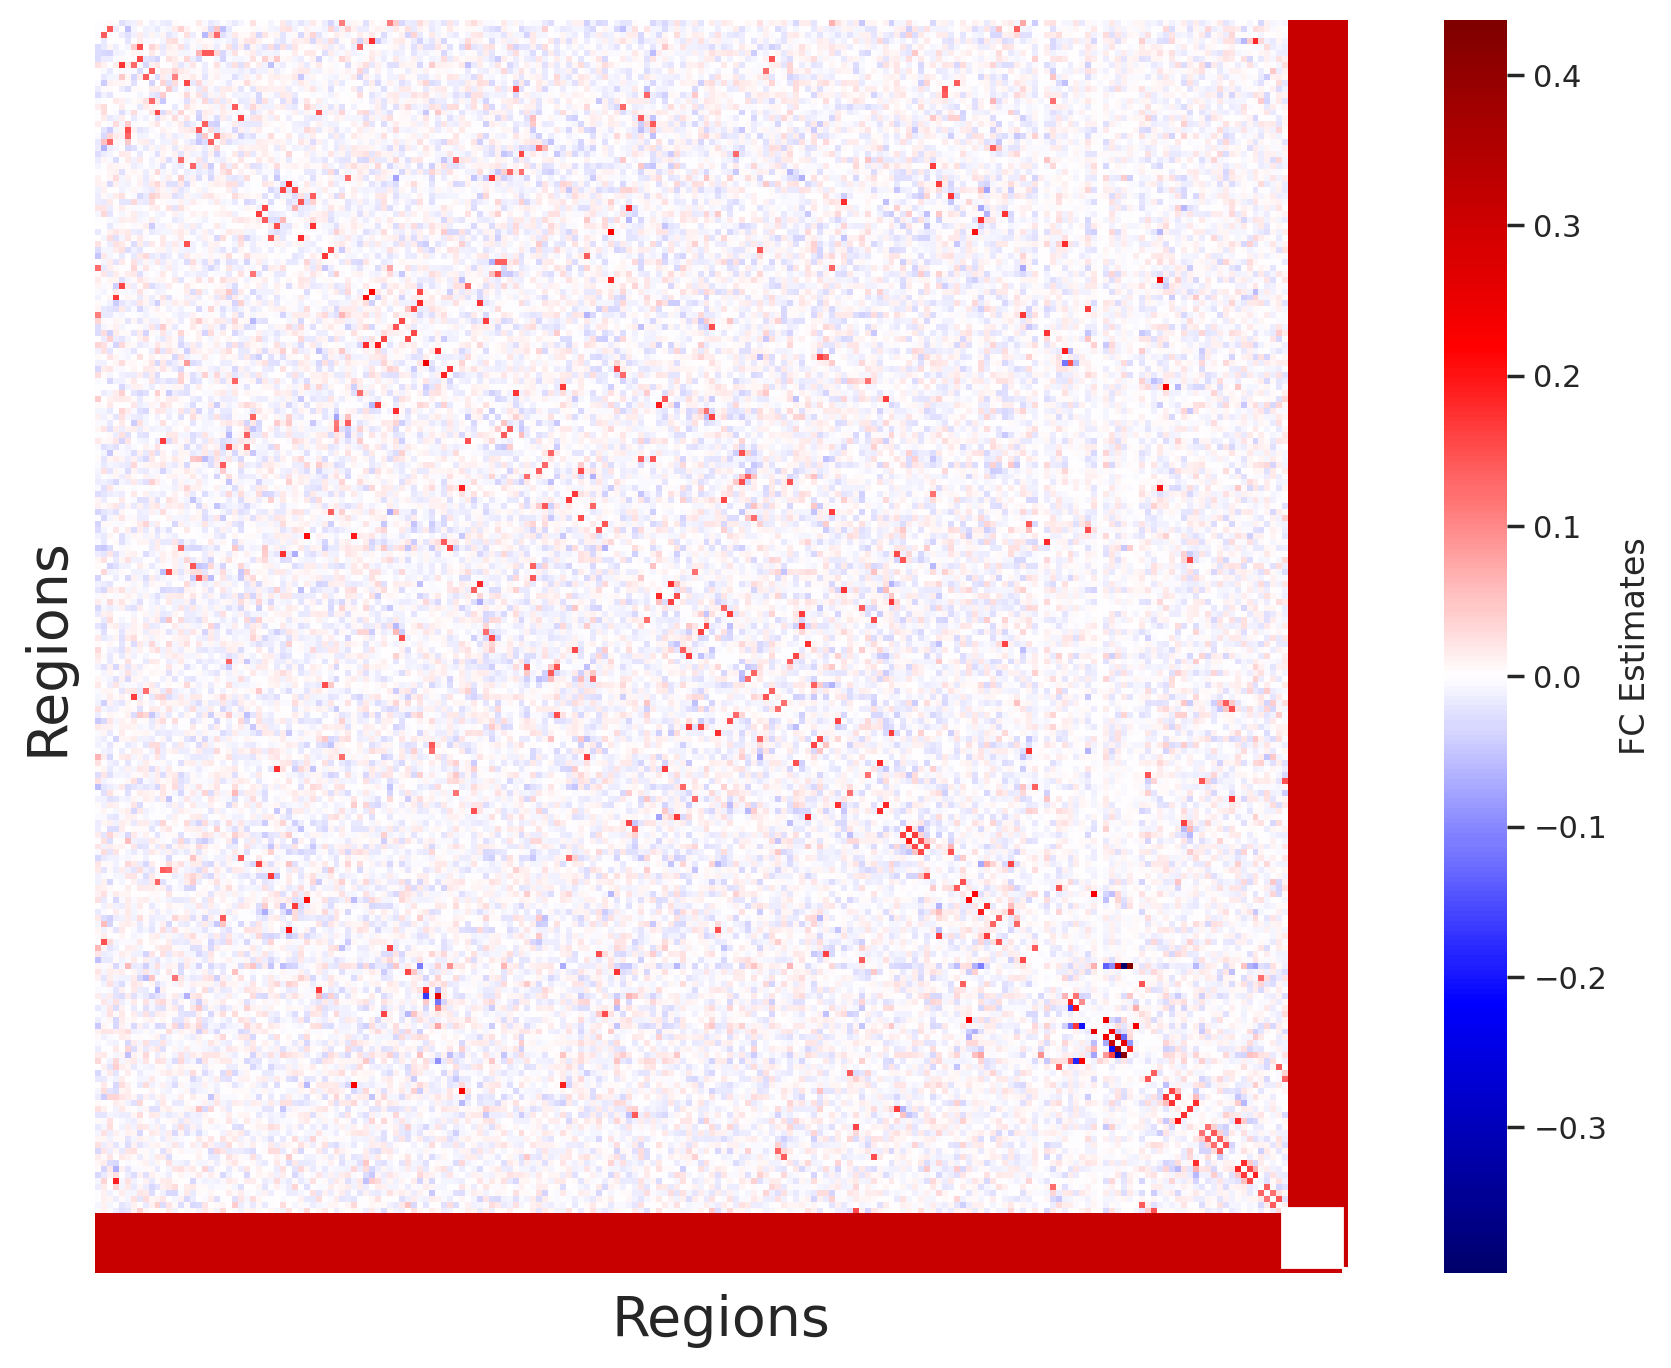

In [110]:
# Scale values between -1 and 1 using np.clip() for greater visualisation
restFC_mreg_scaled = np.clip(restFC_mreg, -1, 1)

# Now calculate the mean connectivity matrix using valid netorder
fcmat = np.mean(restFC_mreg_scaled[netorder, :, :][:, netorder, :], axis=2)

# Visualize the result
fig = actflow.tools.addNetColors_Seaborn(fcmat)

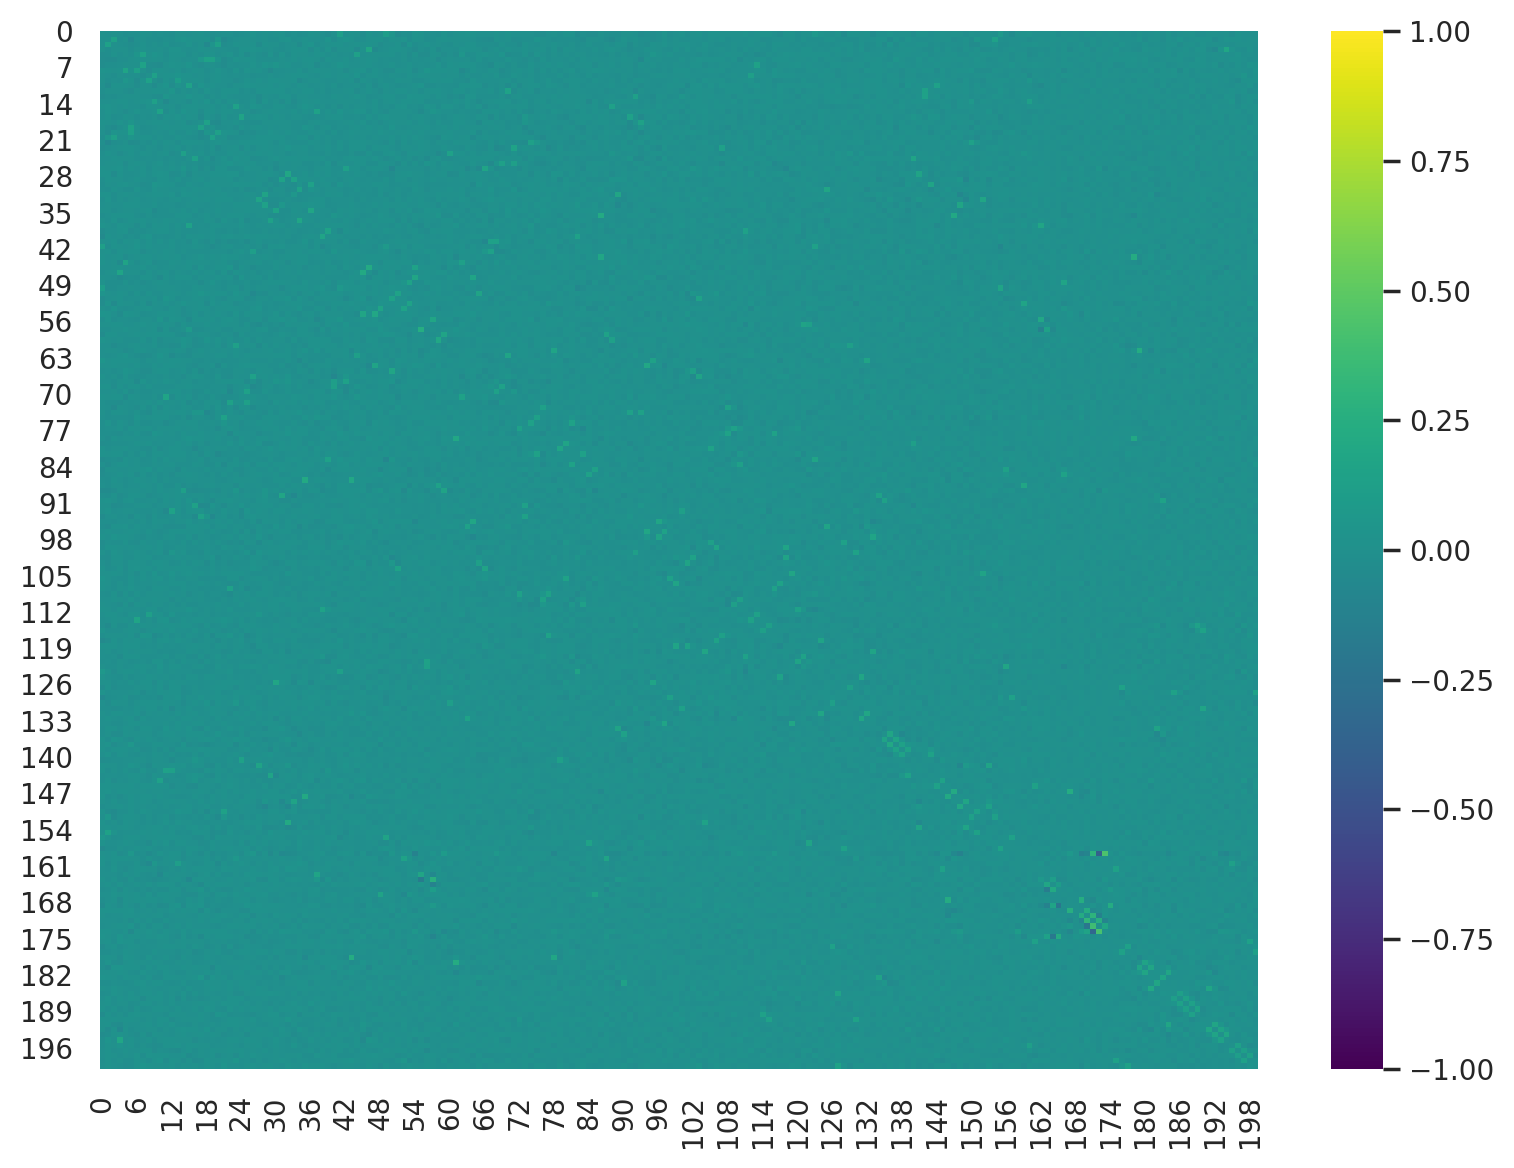

In [113]:
import seaborn as sns
import matplotlib.pyplot as plt

# Adjust color map to highlight small changes
sns.heatmap(fcmat, cmap='viridis', vmin=-1, vmax=1)
plt.show()


## MultiReg on Abide using Task data from HCP

In [114]:
# Parameters
N_ROIS_ABIDE = 200  # Number of ROIs in ABIDE
N_TIMEPOINTS = 200  # Adjust based on your dataset
N_SUBJECTS_ABIDE = 884  # Adjust based on your dataset
TASK_CONDITION_SOCIAL_COGNITION = 22  # Social Cognition Task condition number

# Load ABIDE Resting-State Data
abide_data_dir = '/content/drive/MyDrive/preprocessed_dataset/interpolated_data'
file_paths = glob.glob(os.path.join(abide_data_dir, '*.npy'))

# Initialize a list to store ABIDE resting-state data
restdata_list = []

for file_path in file_paths:
    try:
        data = np.load(file_path)
        if data.shape != (N_ROIS_ABIDE, N_TIMEPOINTS):
            print(f"Skipping {file_path}, unexpected shape {data.shape}")
            continue
        restdata_list.append(data)
    except Exception as e:
        print(f"Error loading file {file_path}: {e}")

if restdata_list:
    restdata_abide = np.stack(restdata_list, axis=2)
    print(f"ABIDE Restdata Shape: {restdata_abide.shape}")
else:
    print("No valid .npy files were loaded.")

Skipping /content/drive/MyDrive/preprocessed_dataset/interpolated_data/restdata.npy, unexpected shape (200, 200, 884)
ABIDE Restdata Shape: (200, 200, 884)


In [115]:
%%time
# Compress HCP predicted_mean from 360 ROIs to 200 ROIs (simple approach: averaging)
# Assuming predicted_mean is a (360, N_TASKS) matrix from your first code
predicted_mean_hcp_compressed = np.mean(predicted_mean, axis=0)  # Average over ROIs (360 -> 200)

CPU times: user 1.5 ms, sys: 0 ns, total: 1.5 ms
Wall time: 1.52 ms


In [130]:
%%time
# Prepare for regression (assuming predicted_mean_hcp_compressed is already a task-based matrix)

# Calculate Multiple-Regression FC based on ABIDE resting-state data
numnodes_abide = restdata_abide.shape[0]  # 200 ROIs from ABIDE
numsubjs_abide = restdata_abide.shape[2]  # 884 subjects in ABIDE
restFC_mreg_abide = np.zeros((numnodes_abide, numnodes_abide, numsubjs_abide), dtype=np.float64)

for scount in np.arange(numsubjs_abide):
    restFC_mreg_abide[:, :, scount] = actflow.connectivity_estimation.multregconn(restdata_abide[:, :, scount])

CPU times: user 1h 12min 9s, sys: 9.47 s, total: 1h 12min 18s
Wall time: 43min 17s


In [138]:
restFC_mreg_abide = np.array(restFC_mreg_abide, copy=True)
restFC_mreg_abide.setflags(write=True)

In [ ]:
%%time

# Check for correct shapes
print("Shape of restFC_mreg_abide:", restFC_mreg_abide.shape)
print("Shape of activations_bycond:", activations_bycond.shape)

# Apply Activity Flow Mapping
actflowOutput_restABIDE_FCMReg_bycond = actflow.actflowcomp.actflowtest(
    activations_bycond,  # Task-based activations
    restFC_mreg_abide    # Resting-state FC
)

Shape of restFC_mreg_abide: (200, 200, 884)
Shape of activations_bycond: (200, 24, 100)


In [ ]:
# Visualize and Compare the Predicted Activations for ABIDE vs HCP Social Cognition Task
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot Predicted Activations for ABIDE Social Cognition
sns.heatmap(predicted_mean_abide_social_cognition, center=0, cmap='seismic', ax=axes[0],
            cbar=True, cbar_kws={'label': 'Activation'},
            vmin=np.min(predicted_mean_abide_social_cognition), vmax=np.max(predicted_mean_abide_social_cognition),
            xticklabels=None, yticklabels=None)
axes[0].set_title("Predicted Activations (ABIDE Social Cognition)")

# Plot Predicted Activations for HCP Social Cognition (Compressed)
sns.heatmap(predicted_mean_hcp_compressed, center=0, cmap='seismic', ax=axes[1],
            cbar=True, cbar_kws={'label': 'Activation'},
            vmin=np.min(predicted_mean_hcp_compressed), vmax=np.max(predicted_mean_hcp_compressed),
            xticklabels=None, yticklabels=None)
axes[1].set_title("Predicted Activations (HCP Social Cognition - Compressed)")

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

# Predictive Model from HCP
## Resting State to Social Cognition

In [ ]:
# Assuming 'restdata' is your input resting-state data for a subject (n_nodes x n_timepoints)
restFC_mreg = np.zeros((numnodes, numnodes, numsubjs))

for scount in np.arange(numsubjs):
    restFC_mreg[:,:,scount] = actflow.connectivity_estimation.multregconn(restdata[:,:,scount])

fcmat = np.mean(restFC_mreg[netorder,:,:][:, netorder,:], axis=2)


<ipython-input-76-dee6393bb6ff>:7: DeprecationWarning: Out of bound index found. This was previously ignored when the indexing result contained no elements. In the future the index error will be raised. This error occurs either due to an empty slice, or if an array has zero elements even before indexing.
(Use `warnings.simplefilter('error')` to turn this DeprecationWarning into an error and get more details on the invalid index.)
  fcmat = np.mean(restFC_mreg[netorder,:,:][:, netorder,:], axis=2)
/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


In [ ]:
task_data = activations_bycond[:, condNum]  # Extract condition data for social cognition task


In [ ]:
features = fcmat.flatten()  # Flatten the FC matrix as input features
target = task_data  # The target variable is the task-based social cognition activity


In [ ]:
# Suppose fcmat is of shape (num_subjects, n_nodes, n_nodes)
num_subjects = fcmat.shape[0]
n_nodes = fcmat.shape[1]

# Flatten the connectivity matrix for each subject (n_subjects, n_nodes^2)
X = fcmat.reshape(num_subjects, -1)

# Ensure the target vector y has the same number of subjects
y = task_data  # This should have shape (num_subjects,)


In [ ]:
print("X shape:", X.shape)
print("y shape:", y.shape)


X shape: (360, 360)
y shape: (360, 100)


In [ ]:
# Example: Let's assume fcmat is the functional connectivity matrix of shape (num_subjects, n_nodes, n_nodes)
num_subjects = fcmat.shape[0]  # Number of subjects
n_nodes = fcmat.shape[1]  # Number of nodes

# Flatten the functional connectivity matrix for each subject into a 1D vector of size n_nodes^2
X = fcmat.reshape(num_subjects, -1)  # Shape (num_subjects, n_nodes^2)

# Check the shape of X
print("Shape of X (features):", X.shape)

# Ensure task_data has the correct shape
y = task_data  # Should be of shape (num_subjects,)
print("Shape of y (target):", y.shape)

# Proceed with training after ensuring shapes are consistent


Shape of X (features): (360, 360)
Shape of y (target): (360, 100)


In [ ]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

# Step 1: Clean or Impute the Data (Handle NaN values)
# Assuming X and y are already available

imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)  # Handle missing values in X
y_imputed = imputer.fit_transform(y)  # Handle missing values in y

# Step 2: Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_imputed, y_imputed, test_size=0.2, random_state=42)

# Step 3: Define the Model
model = Sequential()

# Add input layer and hidden layers
model.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))  # 128 neurons in the first hidden layer
model.add(Dense(64, activation='relu'))  # 64 neurons in the second hidden layer
model.add(Dense(32, activation='relu'))  # 32 neurons in the third hidden layer

# Add output layer with linear activation (since it's regression)
model.add(Dense(y_train.shape[1], activation='linear'))  # Number of outputs = 100

# Step 4: Compile the Model
model.compile(optimizer=Adam(), loss='mean_squared_error', metrics=['mae'])

# Step 5: Train the Model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val))

# Step 6: Evaluate the Model
val_loss, val_mae = model.evaluate(X_val, y_val)
print(f"Validation Loss: {val_loss}, Validation MAE: {val_mae}")

# Step 7: Make Predictions
y_pred = model.predict(X_val)


Epoch 1/100


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 531.8455 - mae: 17.0734 - val_loss: 630.6099 - val_mae: 18.7438
Epoch 2/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 562.8188 - mae: 17.7608 - val_loss: 630.4644 - val_mae: 18.7414
Epoch 3/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 556.0675 - mae: 17.5172 - val_loss: 630.3238 - val_mae: 18.7391
Epoch 4/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 528.5842 - mae: 17.1187 - val_loss: 630.1830 - val_mae: 18.7368
Epoch 5/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 578.1030 - mae: 17.9025 - val_loss: 630.0386 - val_mae: 18.7344
Epoch 6/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 550.3336 - mae: 17.7021 - val_loss: 629.8945 - val_mae: 18.7320
Epoch 7/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 591.6276 - mae: 18.2126 - val_loss: 629.7507 - val_mae: 18.7296
Epoch 8/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 545.3682 - mae: 17.3610 - val_loss: 629.6077 - val_mae: 18.7273
Epoch 9/100
9/9 ━━━━━━━━━━━━━━━━━━━━

In [ ]:
from tensorflow.keras.layers import BatchNormalization, Dense, Dropout

model = tf.keras.Sequential([
    Dense(512, activation='relu', input_shape=(360,)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(100)
])


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

optimizer = Adam(learning_rate=0.001)  # You can experiment with different learning rates

model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])

# Early stopping callback to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)


In [ ]:
from tensorflow.keras.regularizers import l2

model = tf.keras.Sequential([
    Dense(512, activation='relu', kernel_regularizer=l2(0.01), input_shape=(360,)),
    Dense(256, activation='relu', kernel_regularizer=l2(0.01)),
    Dense(100)
])


In [ ]:
from tensorflow.keras.layers import BatchNormalization, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler

# Standardize the input data
scaler = StandardScaler()
X_clean = scaler.fit_transform(X_clean)

# Define the model
model = Sequential([
    Dense(512, activation='relu', input_shape=(360,)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(100)
])

# Compile the model with Adam optimizer and Mean Squared Error loss
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])

# Implement early stopping to avoid overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with early stopping
model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val), callbacks=[early_stopping])


ValueError: Found array with 0 feature(s) (shape=(360, 0)) while a minimum of 1 is required by StandardScaler.

In [ ]:
# Example: Check columns with NaNs
print(np.isnan(X).any(axis=0))  # Check which columns have NaNs


[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  T

# Archived Code (not necessary/doesn't work)

In [ ]:
#USING ACTFLOW MAPPING EXAMPLE CODE
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Set task condition number for Social Mental Task
condNum = 22

# RestFC Predicted Activations
inputdata = np.mean(actflowOutput_restFCMReg_bycond['actPredVector_bytask_bysubj'], axis=2)[:, condNum]
print('Min value: ', np.min(inputdata))
print('Max value: ', np.max(inputdata))

# Flip hemispheres (CAB-NP is left-to-right, wbplot uses right-to-left)
inputdata_flipped = np.zeros(np.shape(inputdata))
inputdata_flipped[0:180] = inputdata[180:360]
inputdata_flipped[180:360] = inputdata[0:180]

# Set colormap based on data range
colormap = 'Reds' if min(inputdata) >= 0 else 'seismic'

# Save predicted activations to file
file_out = "predicted_social_mental.png"
pscalar(
    file_out=file_out,
    pscalars=inputdata_flipped,
    cmap=colormap,
    transparent=True
)

# Display predicted activations
img = mpimg.imread(file_out)
plt.figure()
plt.axis('off')
plt.title('Multreg restFC actflow predictions (Social Mental Task)')
plt.imshow(img)

# ----------------------------- #
# Actual Activations
inputdata = np.mean(activations_bycond, axis=2)[:, condNum]
print('Min value: ', np.min(inputdata))
print('Max value: ', np.max(inputdata))

# Flip hemispheres again
inputdata_flipped = np.zeros(np.shape(inputdata))
inputdata_flipped[0:180] = inputdata[180:360]
inputdata_flipped[180:360] = inputdata[0:180]

# Set colormap again
colormap = 'Reds' if min(inputdata) >= 0 else 'seismic'

# Save actual activations to file
file_out = "actual_social_mental.png"
pscalar(
    file_out=file_out,
    pscalars=inputdata_flipped,
    cmap=colormap,
    transparent=True
)

# Display actual activations
img = mpimg.imread(file_out)
plt.figure()
plt.axis('off')
plt.title('Actual Activations (Social Mental Task)')
plt.imshow(img)

plt.show()

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Min value:  -15.468213175516714
Max value:  33.718228513607485


FileNotFoundError: [Errno 2] No such file or directory: 'predicted_social_mental.png'

**Scaling could improve the data? May not be necessary:**

- Method 1:subtract alpha and divide by scaling factor
- Method 2: add alpha and multiply scaling factor



In [ ]:
#SCALING METHOD 1
# Compute mean predicted and actual activations
predicted_mean = np.mean(actflowOutput_restFCMReg_bycond['actPredVector_bytask_bysubj'], axis=2)
actual_mean = np.mean(activations_bycond, axis=2)

# Compute per-region correction factor (blend ratio & offset)
scaling_factors = np.mean(predicted_mean / actual_mean, axis=1, keepdims=True)
offset_correction = np.mean(predicted_mean - actual_mean, axis=1, keepdims=True)

# Blend both scaling and offset correction (weight to prevent overcorrection)
alpha = 0.5  # Adjust alpha between 0 and 1 to tune correction strength
adjusted_predicted_mean = (predicted_mean - alpha * offset_correction) / (scaling_factors ** alpha)


<ipython-input-121-2c58717ce6ed>:12: RuntimeWarning: invalid value encountered in sqrt
  adjusted_predicted_mean = (predicted_mean - alpha * offset_correction) / (scaling_factors ** alpha)


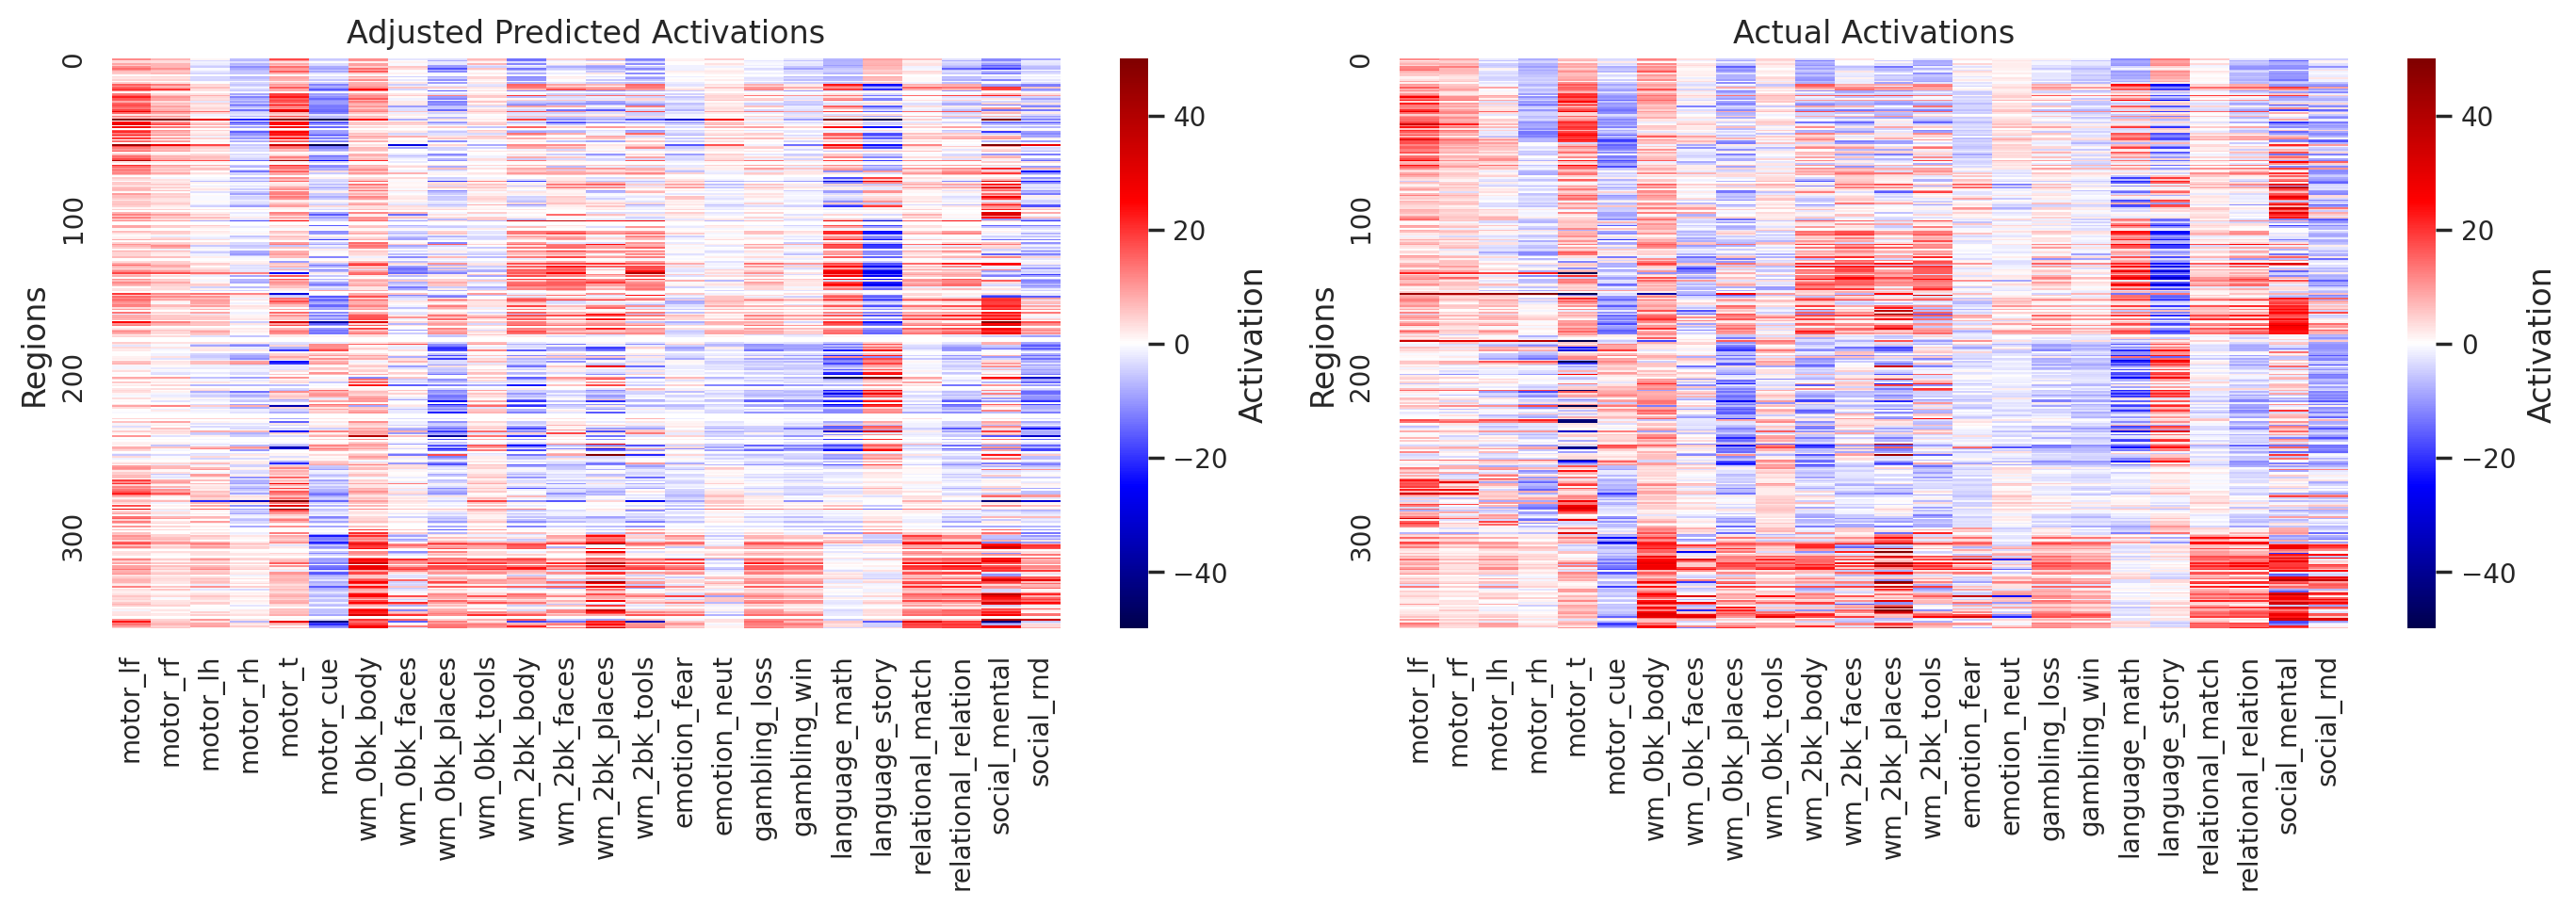

In [ ]:
# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot adjusted predicted activations
sns.heatmap(adjusted_predicted_mean[netorder, :], center=0, cmap='seismic',
            cbar=True, cbar_kws={'label': 'Activation'}, yticklabels=100,
            xticklabels=taskConditions, ax=axes[0],
            vmin=-50, vmax=50)  # Set fixed color scale
axes[0].set_title('Adjusted Predicted Activations')
axes[0].set_ylabel('Regions')

# Plot actual activations
sns.heatmap(np.mean(activations_bycond, axis=2)[netorder, :], center=0, cmap='seismic',
            cbar=True, cbar_kws={'label': 'Activation'}, yticklabels=100,
            xticklabels=taskConditions, ax=axes[1],
            vmin=-50, vmax=50)  # Set fixed color scale
axes[1].set_title('Actual Activations')
axes[1].set_ylabel('Regions')

# Adjust layout for better spacing
plt.tight_layout()
plt.show()


In [ ]:
#SCALING METHOD 2 (seems to work better)
# Compute mean predicted and actual activations
predicted_mean = np.mean(actflowOutput_restFCMReg_bycond['actPredVector_bytask_bysubj'], axis=2)
actual_mean = np.mean(activations_bycond, axis=2)

# Compute per-region correction factor
scaling_factors = np.mean(predicted_mean / actual_mean, axis=1, keepdims=True)

# Compute per-region offset correction
offset_correction = np.mean(actual_mean - predicted_mean, axis=1, keepdims=True)

# Fine-tune the correction by introducing a **gentle boost**
alpha = 1  # Keeps it small to avoid overcorrection
adjusted_predicted_mean = (predicted_mean + alpha * offset_correction) * (scaling_factors ** (1 - alpha))


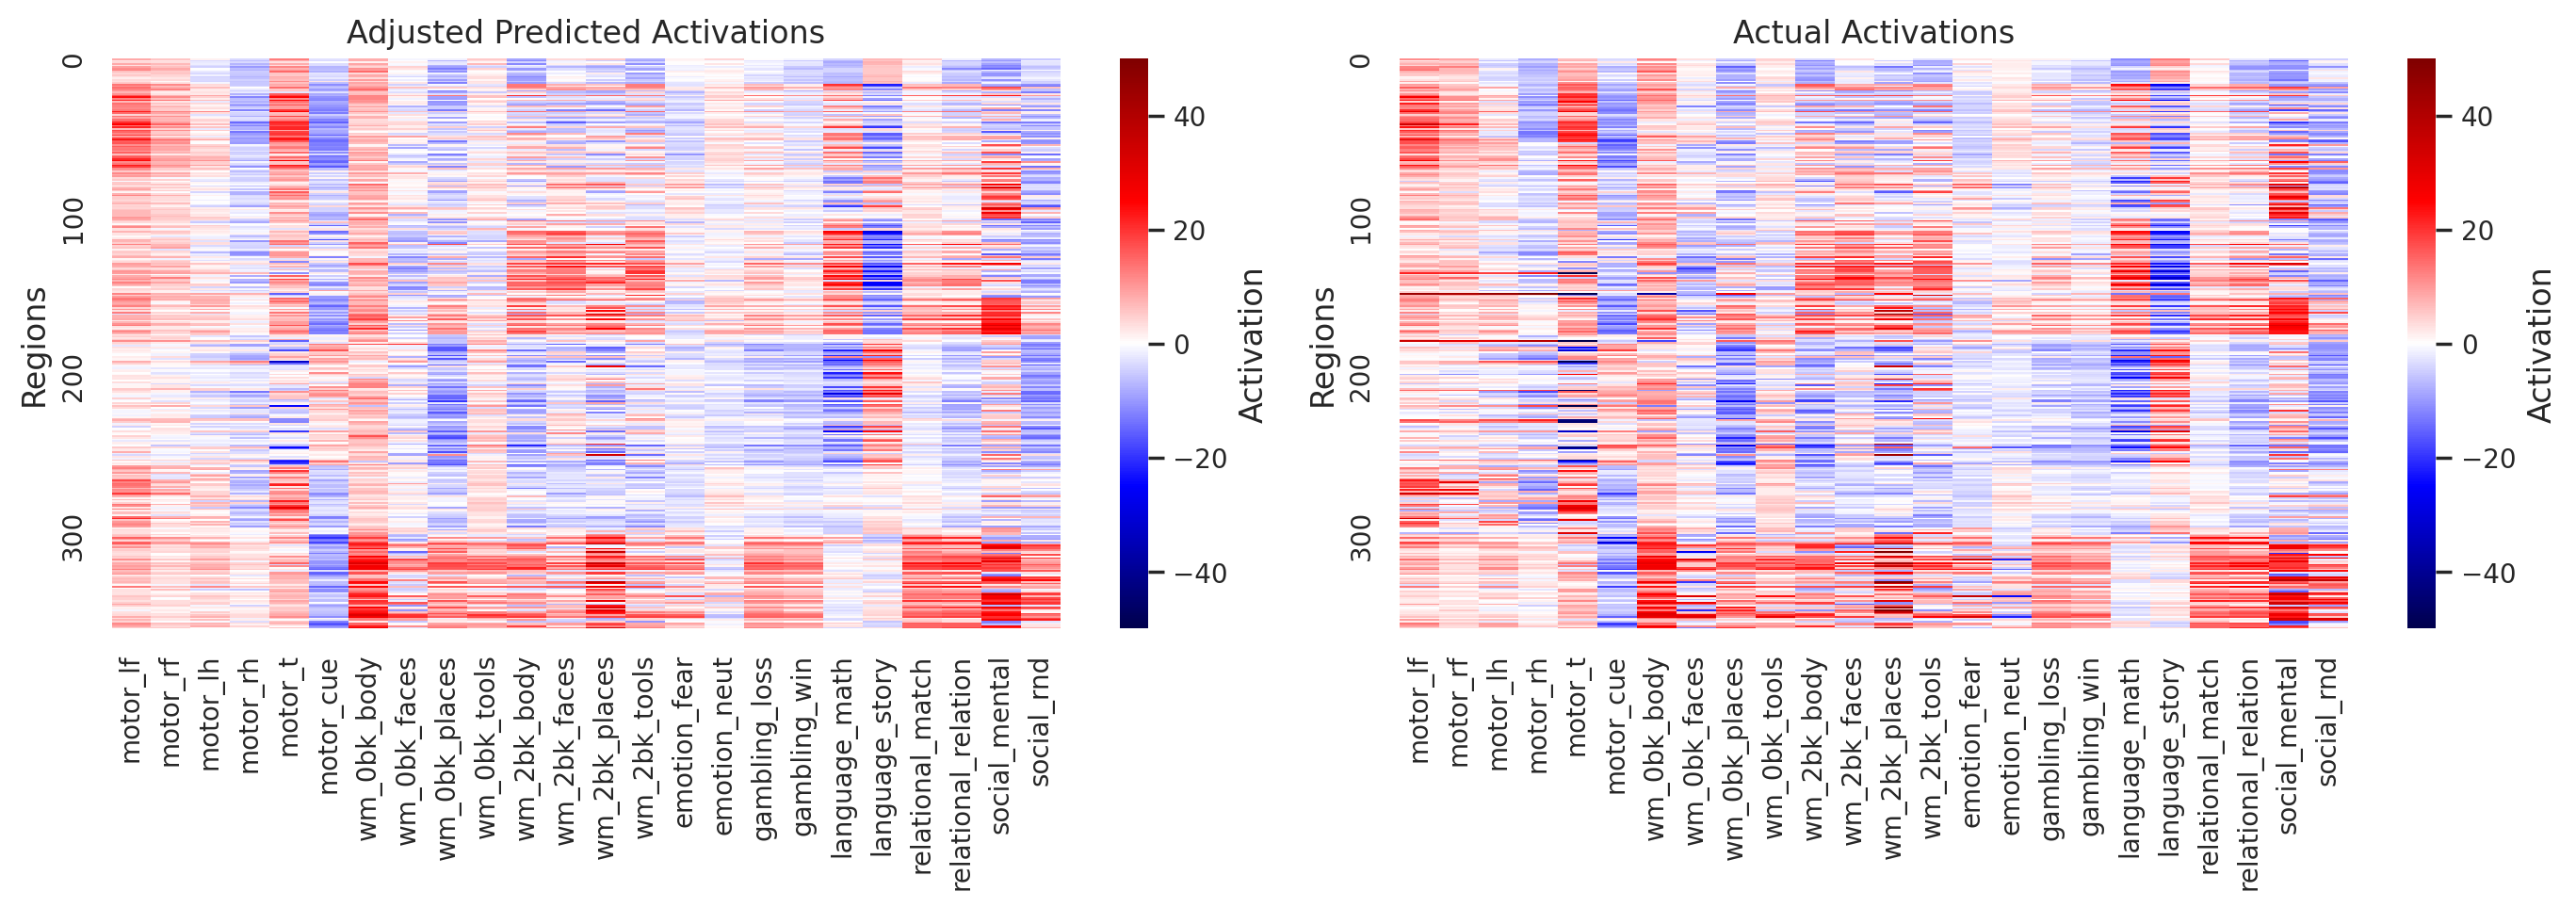

In [ ]:
# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot adjusted predicted activations
sns.heatmap(adjusted_predicted_mean[netorder, :], center=0, cmap='seismic',
            cbar=True, cbar_kws={'label': 'Activation'}, yticklabels=100,
            xticklabels=taskConditions, ax=axes[0],
            vmin=-50, vmax=50)  # Set fixed color scale
axes[0].set_title('Adjusted Predicted Activations')
axes[0].set_ylabel('Regions')

# Plot actual activations
sns.heatmap(np.mean(activations_bycond, axis=2)[netorder, :], center=0, cmap='seismic',
            cbar=True, cbar_kws={'label': 'Activation'}, yticklabels=100,
            xticklabels=taskConditions, ax=axes[1],
            vmin=-50, vmax=50)  # Set fixed color scale
axes[1].set_title('Actual Activations')
axes[1].set_ylabel('Regions')

# Adjust layout for better spacing
plt.tight_layout()
plt.show()


In [ ]:
#Plotting brain surface images in-line, FC-based predictions

condNum=22 #condition 9 = relational reasoning

#RestFC predicted
inputdata=np.mean(actflowOutput_restFCMReg_bycond['actPredVector_bytask_bysubj'],axis=2)[:,condNum]
print('Min value: ', np.min(inputdata))
print('Max value: ', np.max(inputdata))
#flip hemispheres, since CAB-NP is ordered left-to-right, while wbplot uses right-to-left
inputdata_flipped=np.zeros(np.shape(inputdata))
inputdata_flipped[0:180]=inputdata[180:360]
inputdata_flipped[180:360]=inputdata[0:180]
file_out="out.png"
#Set to all reds if no negative values
if min(inputdata) >= 0:
    colormap='Reds'
else:
    colormap='seismic'
pscalar(
        file_out=file_out,
        pscalars=inputdata_flipped,
        cmap=colormap,
        transparent=True)
img = mpimg.imread(file_out)
plt.figure()
plt.axis('off')
plt.title('Multreg restFC actflow predictions (relational reasoning)')
plt.imshow(img)

#Actual activity
inputdata=np.mean(activations_bycond,axis=2)[:,condNum]
print('Min value: ', np.min(inputdata))
print('Max value: ', np.max(inputdata))
#flip hemispheres, since CAB-NP is ordered left-to-right, while wbplot uses right-to-left
inputdata_flipped=np.zeros(np.shape(inputdata))
inputdata_flipped[0:180]=inputdata[180:360]
inputdata_flipped[180:360]=inputdata[0:180]
file_out="out.png"
#Set to all reds if no negative values
if min(inputdata) >= 0:
    colormap='Reds'
else:
    colormap='seismic'
pscalar(
        file_out=file_out,
        pscalars=inputdata_flipped,
        cmap=colormap,
        transparent=True)
img = mpimg.imread(file_out)
plt.figure()
plt.axis('off')
plt.title('Actual activations (relational reasoning)')
plt.imshow(img)

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Min value:  -15.468213175516714
Max value:  33.718228513607485


FileNotFoundError: [Errno 2] No such file or directory: 'out.png'

In [ ]:
from sklearn.linear_model import Ridge
restFC__mrfc=np.zeros((N_PARCELS, N_PARCELS, N_SUBJECTS))

for subj_idx, subject in enumerate(range(N_SUBJECTS)):
  X=restdata[:,:,subj_idx].T #timepoints & regions
  restFC=np.zeros((N_PARCELS, N_PARCELS))

  for region in range(N_PARCELS):
    y= X[:, region] #target region's time series
    X_other=np.delete(X, region, axis=1) #remove target from predictors

    model=Ridge(alpha=1.0) #regularised multiregression
    model.fit(X_other, y)
    restFC[region, np.arange(N_PARCELS) != region] = model.coef_

  restFC__mrfc[:,:,subj_idx]=restFC #storing subject level MRFC

  print("==Activity flow mapping using correlation based FC==")
  actflowOutput_restFCCorr_bycond= actflow.actflowcomp.actflowtest(activations_bycond, restFC_corr)

  print("==Activity flow mapping using multi-regression FC==")
  actflowOutput_restFCCorr_bycond= actflow.actflowcomp.actflowtest(activations_bycond, restFC__mrfc)

==Activity flow mapping using correlation based FC==
===Comparing prediction accuracies between models (similarity between predicted and actual brain activation patterns)===
 
==Comparisons between predicted and actual activation patterns, across all conditions and nodes:==
--Compare-then-average (calculating prediction accuracies before cross-subject averaging):
Each comparison based on 24 conditions across 360 nodes, p-values based on 100 subjects (cross-subject variance in comparisons)
 
Mean Pearson r = 0.48, t-value vs. 0: 42.51, p-value vs. 0: 2.150275303421664e-65
 
Mean % variance explained (R^2 score, coeff. of determination) = -2398.02
 
Mean MAE (mean absolute error) = 751.73
 
Note: Pearson r and Pearson r^2 are scale-invariant, while R^2 and MAE are not. R^2 units: percentage of the to-be-predicted data's unscaled variance, ranging from negative infinity (because prediction errors can be arbitrarily large) to positive 1. See https://scikit-learn.org/stable/modules/generate

/usr/local/lib/python3.11/dist-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.11/dist-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/usr/local/lib/python3.11/dist-packages/scipy/stats/_stats_py.py:1087: RuntimeWarning: divide by zero encountered in divide
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
/usr/local/lib/python3.11/dist-packages/scipy/stats/_stats_py.py:1087: RuntimeWarning: invalid value encountered in double_scalars
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero


==Activity flow mapping using correlation based FC==
===Comparing prediction accuracies between models (similarity between predicted and actual brain activation patterns)===
 
==Comparisons between predicted and actual activation patterns, across all conditions and nodes:==
--Compare-then-average (calculating prediction accuracies before cross-subject averaging):
Each comparison based on 24 conditions across 360 nodes, p-values based on 100 subjects (cross-subject variance in comparisons)
 
Mean Pearson r = 0.48, t-value vs. 0: 42.51, p-value vs. 0: 2.150275303421664e-65
 
Mean % variance explained (R^2 score, coeff. of determination) = -2398.02
 
Mean MAE (mean absolute error) = 751.73
 
Note: Pearson r and Pearson r^2 are scale-invariant, while R^2 and MAE are not. R^2 units: percentage of the to-be-predicted data's unscaled variance, ranging from negative infinity (because prediction errors can be arbitrarily large) to positive 1. See https://scikit-learn.org/stable/modules/generate

/usr/local/lib/python3.11/dist-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.11/dist-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


==Activity flow mapping using correlation based FC==
===Comparing prediction accuracies between models (similarity between predicted and actual brain activation patterns)===
 
==Comparisons between predicted and actual activation patterns, across all conditions and nodes:==
--Compare-then-average (calculating prediction accuracies before cross-subject averaging):
Each comparison based on 24 conditions across 360 nodes, p-values based on 100 subjects (cross-subject variance in comparisons)
 
Mean Pearson r = 0.48, t-value vs. 0: 42.51, p-value vs. 0: 2.150275303421664e-65
 
Mean % variance explained (R^2 score, coeff. of determination) = -2398.02
 
Mean MAE (mean absolute error) = 751.73
 
Note: Pearson r and Pearson r^2 are scale-invariant, while R^2 and MAE are not. R^2 units: percentage of the to-be-predicted data's unscaled variance, ranging from negative infinity (because prediction errors can be arbitrarily large) to positive 1. See https://scikit-learn.org/stable/modules/generate

/usr/local/lib/python3.11/dist-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.11/dist-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


==Activity flow mapping using correlation based FC==
===Comparing prediction accuracies between models (similarity between predicted and actual brain activation patterns)===
 
==Comparisons between predicted and actual activation patterns, across all conditions and nodes:==
--Compare-then-average (calculating prediction accuracies before cross-subject averaging):
Each comparison based on 24 conditions across 360 nodes, p-values based on 100 subjects (cross-subject variance in comparisons)
 
Mean Pearson r = 0.48, t-value vs. 0: 42.51, p-value vs. 0: 2.150275303421664e-65
 
Mean % variance explained (R^2 score, coeff. of determination) = -2398.02
 
Mean MAE (mean absolute error) = 751.73
 
Note: Pearson r and Pearson r^2 are scale-invariant, while R^2 and MAE are not. R^2 units: percentage of the to-be-predicted data's unscaled variance, ranging from negative infinity (because prediction errors can be arbitrarily large) to positive 1. See https://scikit-learn.org/stable/modules/generate

KeyboardInterrupt: 

In [ ]:
#comparing Pearson FC and Multiregression FC
corr_FC_mean=np.mean(restFC_corr, axis=2)
mrfc_FC_mean= np.mean(restFC__mrfc, axis=2)
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.heatmap(corr_FC_mean, cmaps= "coolwarm", centre=0)
plt.title("Pearson FC")
plt.subplot(1,2,2)
sns.heatmap(mrfc_FC_mean, cmaps= "coolwarm", centre=0)
plt.title("Multiregression FC")

# Archive (from NMA)

# Resting-state analyses

Load a single run of resting-state data:

In [ ]:
help(load_timeseries)

Help on function load_timeseries in module __main__:

load_timeseries(subject, name, dir, runs=None, concat=True, remove_mean=True)
    Load timeseries data for a single subject.
    
    Args:
      subject (int): 0-based subject ID to load
      name (str) : Name of experiment ("rest" or name of task) to load
      dir (str) : data directory
      run (None or int or list of ints): 0-based run(s) of the task to load,
        or None to load all runs.
      concat (bool) : If True, concatenate multiple runs in time
      remove_mean (bool) : If True, subtract the parcel-wise mean
    
    Returns
      ts (n_parcel x n_tp array): Array of BOLD data values



In [ ]:
timeseries = load_timeseries(subject=0,
                             name="rest",
                             dir=os.path.join(HCP_DIR, "hcp_rest"),
                             runs=1)
print(timeseries.shape)  # n_parcel x n_timepoint

(360, 1200)


Load a concatenated resting-state timeseries (using all runs' data) for each subject:

In [ ]:
timeseries_rest = []
for subject in subjects:
  ts_concat = load_timeseries(subject, name="rest",
                              dir=os.path.join(HCP_DIR, "hcp_rest"))
  timeseries_rest.append(ts_concat)

## Run a simple correlation-based "functional connectivity" analysis

Generate a correlation matrix (showing "functional connectivity" or FC) for each subject and plot the group average:

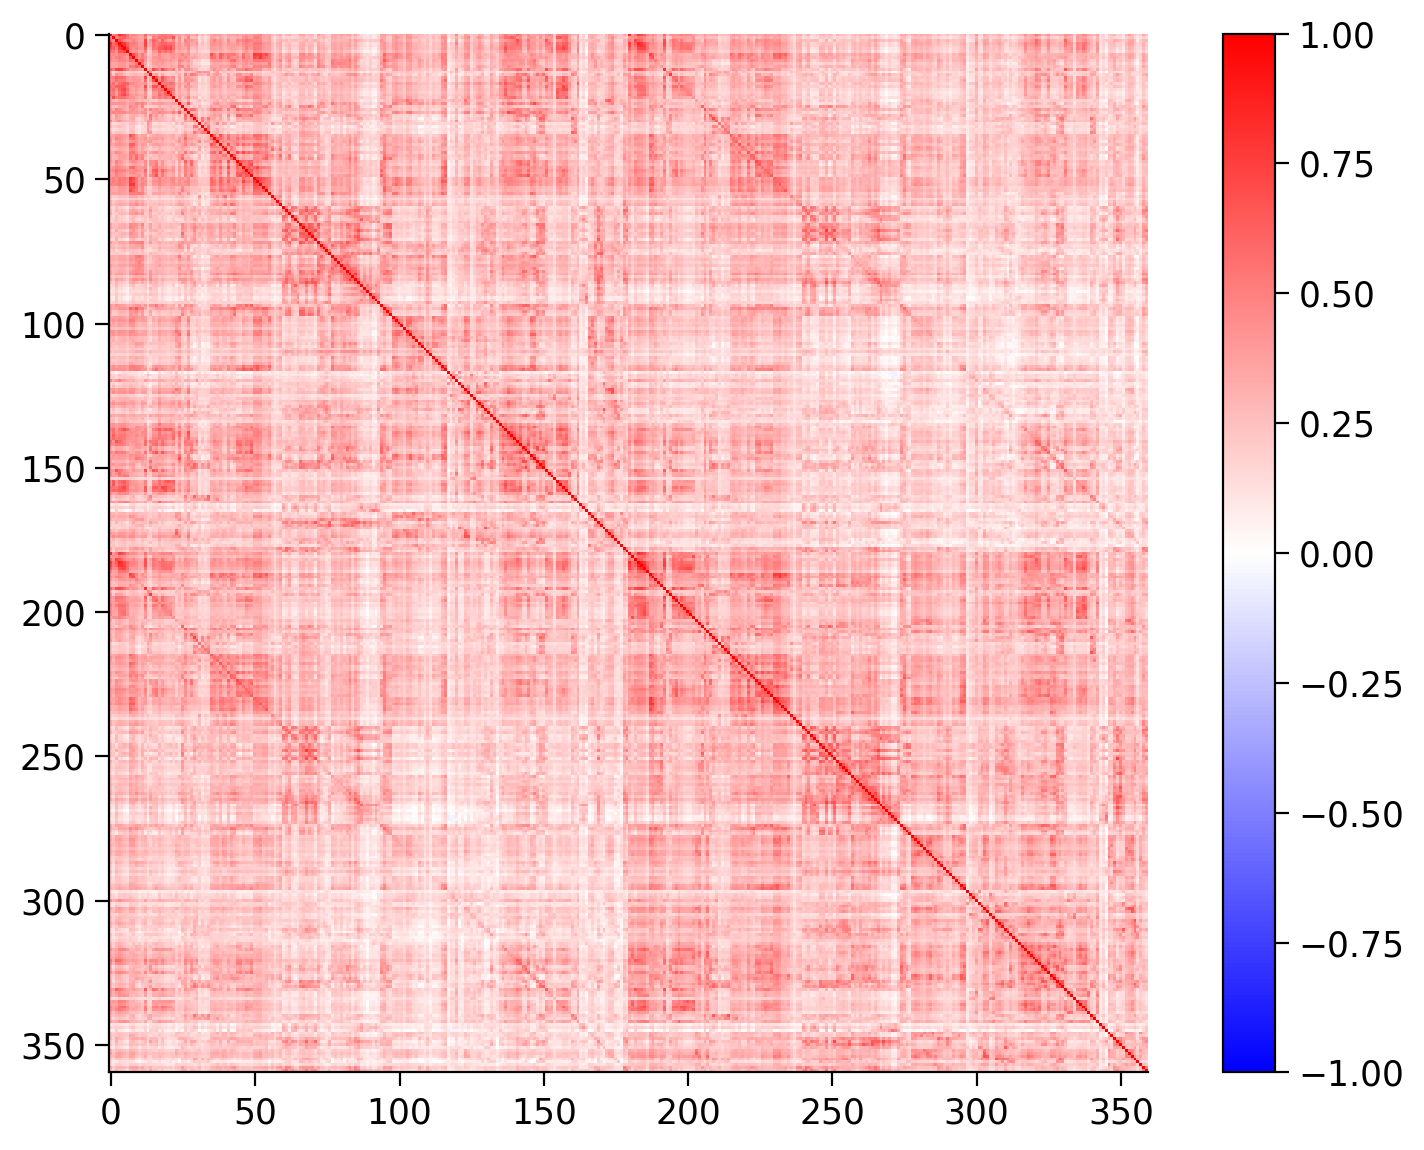

In [ ]:
fc = np.zeros((N_SUBJECTS, N_PARCELS, N_PARCELS))
for sub, ts in enumerate(timeseries_rest):
  fc[sub] = np.corrcoef(ts)

group_fc = fc.mean(axis=0)

plt.figure()
plt.imshow(group_fc, interpolation="none", cmap="bwr", vmin=-1, vmax=1)
plt.colorbar()
plt.show()

Plot the profile of FC values between a particular "seed" parcel and every parcel in the dataset, separated by hemisphere:

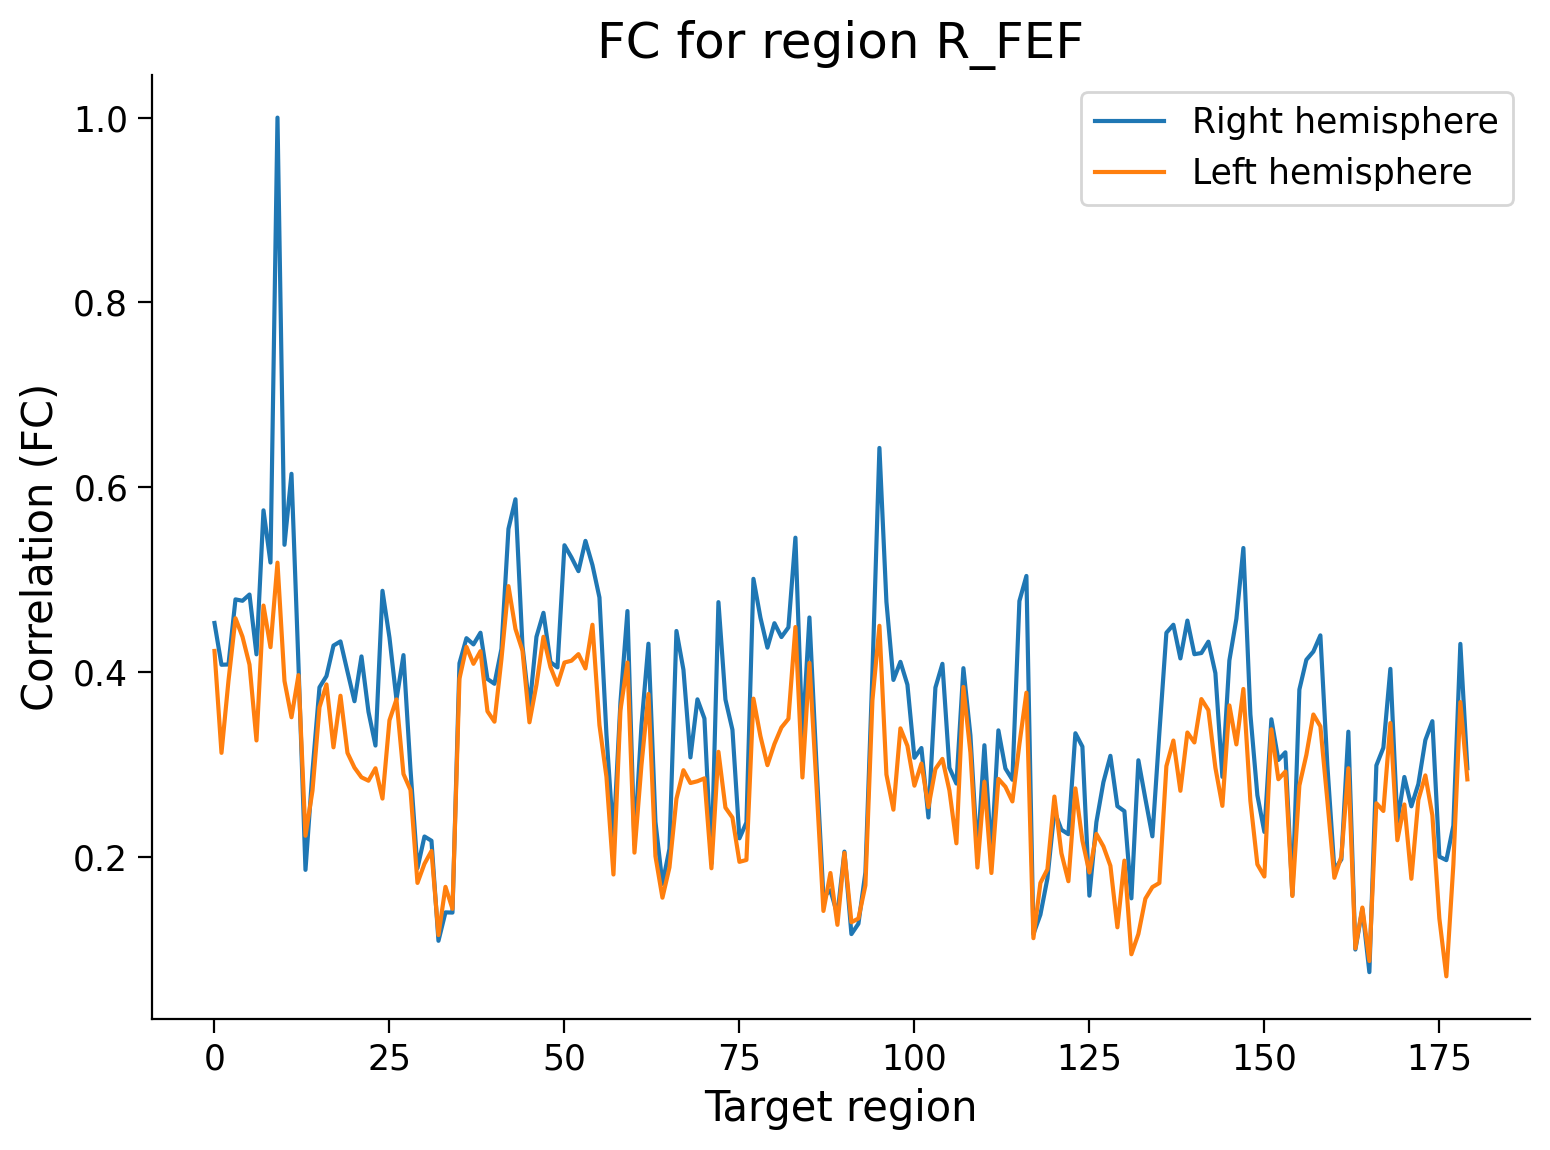

In [ ]:
seed_roi = "R_FEF"  # name of seed parcel
ind = region_info["name"].index(seed_roi)

hemi_fc = np.split(group_fc, 2)

# Plot the FC profile across the right and left hemisphere target regions
plt.figure()
for i, hemi_fc in enumerate(hemi_fc):
  plt.plot(hemi_fc[:, ind], label=f"{HEMIS[i]} hemisphere")
plt.title(f"FC for region {seed_roi}")
plt.xlabel("Target region")
plt.ylabel("Correlation (FC)")
plt.legend()
plt.show()

Threshold the correlation matrix to produce a connectome, and plot it:

In [ ]:
plotting.view_connectome(group_fc, atlas["coords"], edge_threshold="99%")

# Task analyses

Description of each task, task timing, and conditions is located [here](https://protocols.humanconnectome.org/HCP/3T/task-fMRI-protocol-details.html).

These are the condition names for each task:

```
- MOTOR: cue, lf, lh, rf, rh, t
- WM:
    0bk_body, 0bk_faces, 0bk_nir, 0bk_placed, 0bk_tools,
    2bk_body, 2bk_faces, 2bk_nir, 2bk_placed, 2bk_tools,
    0bk_cor, 0bk_err,
    2bk_cor, 2bk_err,
    all_bk_cor, all_bk_err
- EMOTION: feat, neutral
- GAMBLING: loss, loss_event, win, win_event, neut_event
- LANGUAGE:
    cue,
    math, story
    present_math, present_story,
    question_math, question_story,
    response_math, response_story
- RELATIONAL: error, match, relation
- SOCIAL: mental_resp, mental, other_resp, rnd
```

## Load individual runs for a given task

Load each subject's data for a specific task, separately for each run:

In [ ]:
timeseries_task = []
for subject in subjects:
  timeseries_task.append(load_timeseries(subject, "motor",
                                         dir=os.path.join(HCP_DIR, "hcp_task"),
                                         concat=False))

## Run a simple subtraction analysis

In [ ]:
help(load_evs)

Help on function load_evs in module __main__:

load_evs(subject, name, condition, dir)
    Load EV (explanatory variable) data for one task condition.
    
    Args:
      subject (int): 0-based subject ID to load
      name (str) : Name of task
      condition (str) : Name of condition
      dir (str) : data directory
    
    Returns
      evs (list of dicts): A dictionary with the onset, duration, and amplitude
        of the condition for each run.



In [ ]:
help(selective_average)

Help on function selective_average in module __main__:

selective_average(timeseries_data, ev, skip=0)
    Take the temporal mean across frames for a given condition.
    
    Args:
      timeseries_data (array or list of arrays): n_parcel x n_tp arrays
      ev (dict or list of dicts): Condition timing information
      skip (int) : Ignore this many frames at the start of each trial, to account
        for hemodynamic lag
    
    Returns:
      avg_data (1D array): Data averagted across selected image frames based
      on condition timing



In [ ]:
task = "motor"
conditions = ["lf", "rf"]  # Run a substraction analysis between two conditions

contrast = []
for subject in subjects:

  # Get the average signal in each region for each condition
  evs = [load_evs(subject, task, cond, dir=os.path.join(HCP_DIR, "hcp_task")) for cond in conditions]
  avgs = [selective_average(timeseries_task[subject], ev) for ev in evs]

  # Store the region-wise difference
  contrast.append(avgs[0] - avgs[1])

group_contrast = np.mean(contrast, axis=0)

Plot group-averaged contrast value across regions:

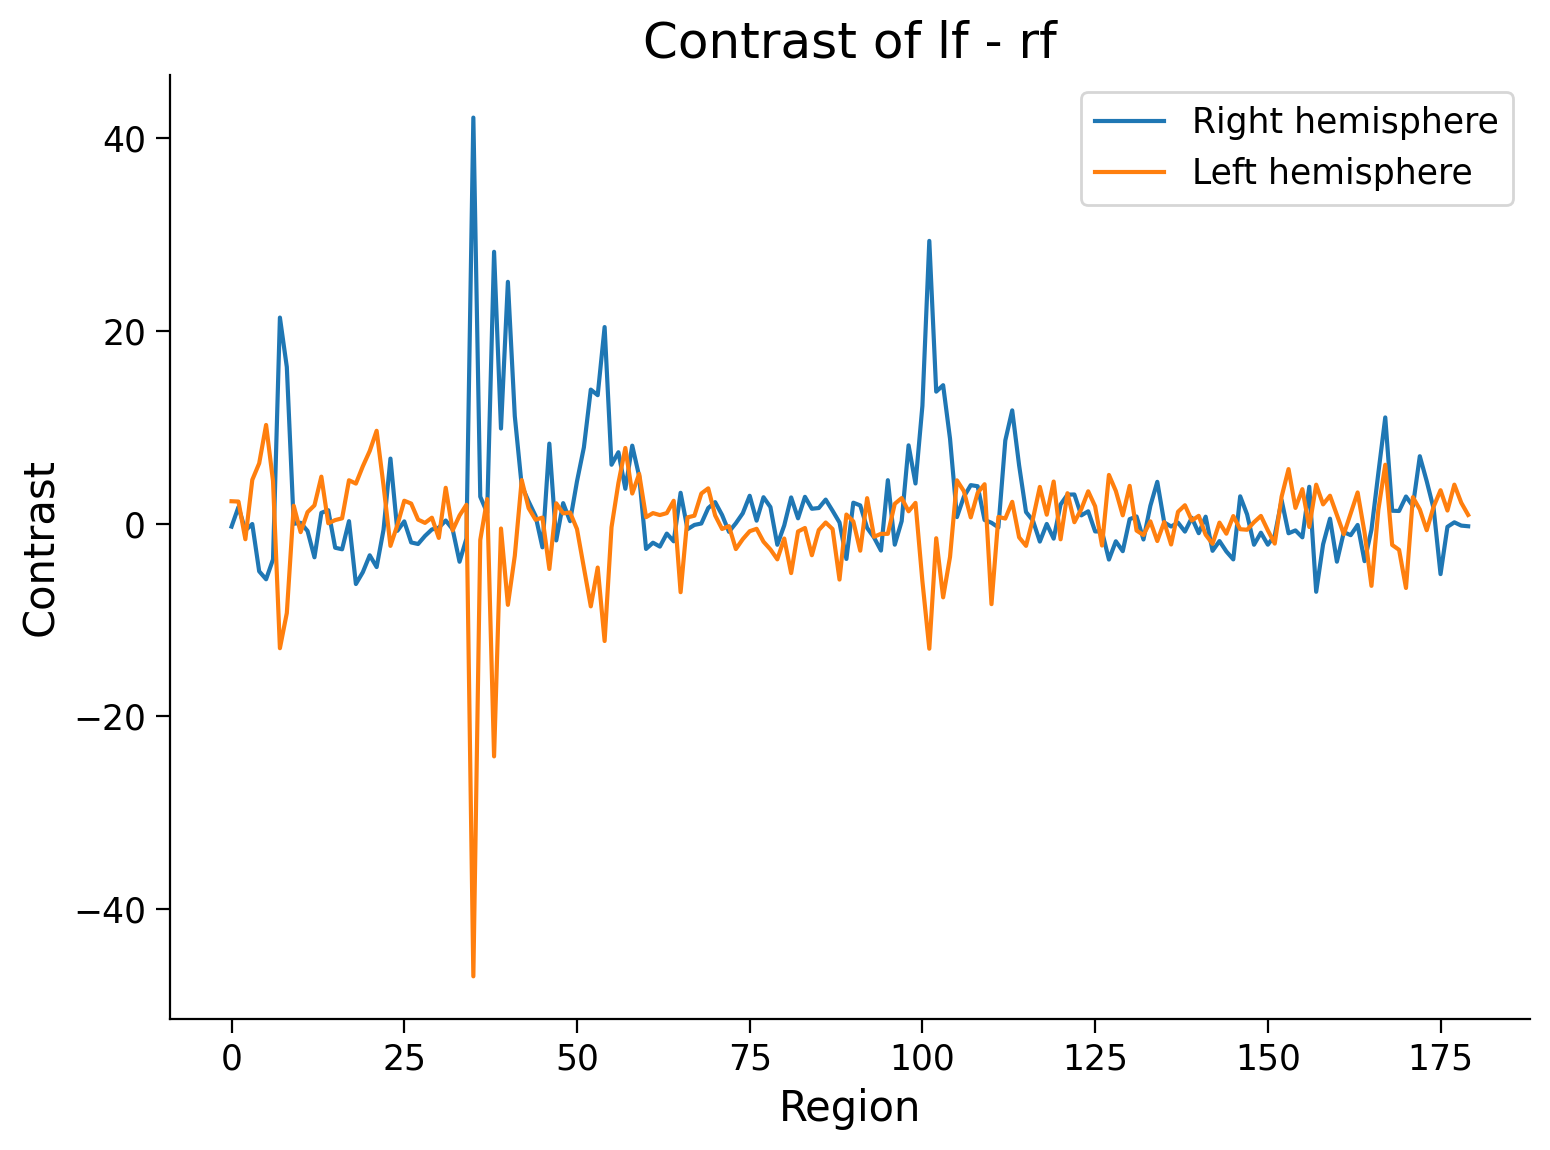

In [ ]:
hemi_contrasts = np.split(group_contrast, 2)

plt.figure()
for i, hemi_contrast in enumerate(hemi_contrasts):
  plt.plot(hemi_contrast, label=f"{HEMIS[i]} hemisphere")

plt.title(f"Contrast of {conditions[0]} - {conditions[1]}")
plt.xlabel("Region")
plt.ylabel('Contrast')
plt.legend()
plt.show()

Plot the regional values on the surface of one hemisphere:

In [ ]:
fsaverage = datasets.fetch_surf_fsaverage()
surf_contrast = group_contrast[atlas["labels_L"]]
plotting.view_surf(fsaverage['infl_left'], surf_contrast, vmax=15)

## Characterize values by functional network

Average the contrast values within parcels belonging to each network and plot:

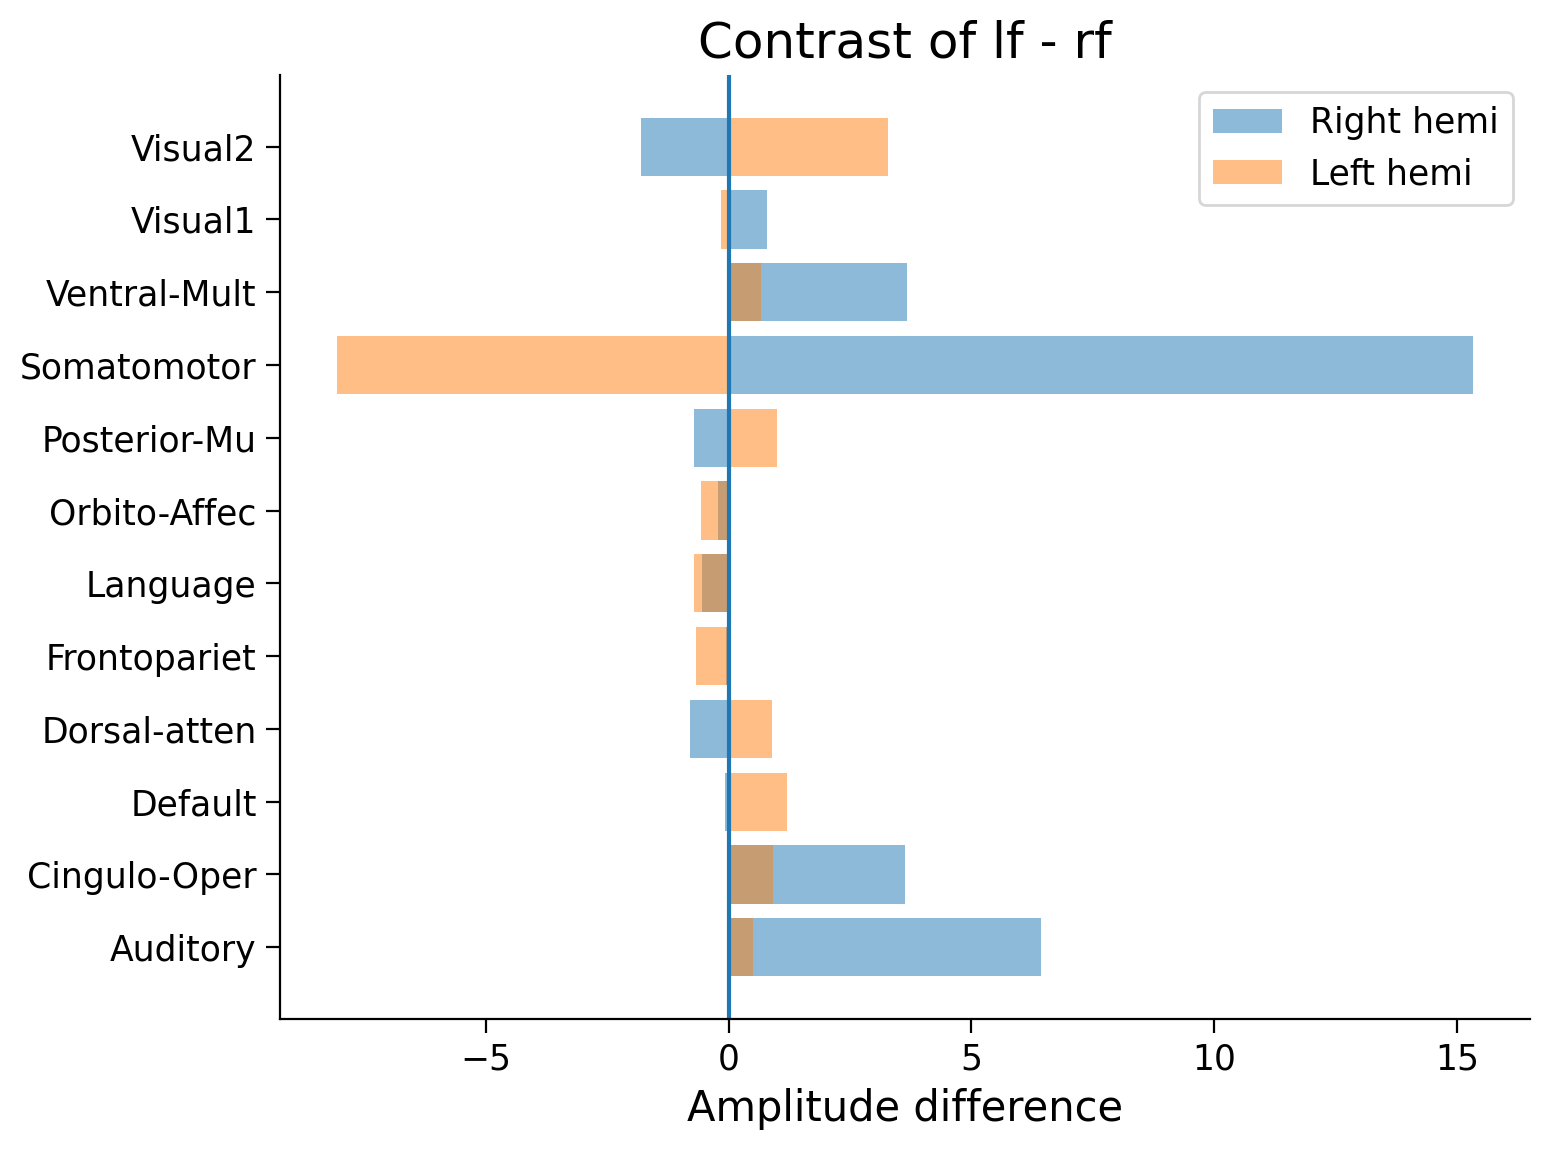

In [ ]:
# Get unique network labels
network_names = np.unique(region_info["network"])

hemi_networks = np.split(region_info["network"], 2)
hemi_contrasts = np.split(group_contrast, 2)

plt.figure()
# Get and plot mean contrast value per network, by hemisphere
for hemi, hemi_network, hemi_contrast in zip(HEMIS, hemi_networks, hemi_contrasts):
  network_vals = []
  for network in network_names:
    network_vals.append(hemi_contrast[hemi_network == network].mean())
  plt.barh(network_names, network_vals, alpha=.5, label=f"{hemi} hemi")

plt.axvline(0)
plt.xlabel("Amplitude difference")
plt.title(f"Contrast of {conditions[0]} - {conditions[1]}")
plt.legend()
plt.show()

# Behavioral covariates


## Task performance measures

The dataset also includes aggregate behavior for each task run stored in task-specific `.csv` files. It is possible to load and work with these files using `numpy`:

In [ ]:
wm_behavior = np.genfromtxt(os.path.join(HCP_DIR, "hcp", "behavior", "wm.csv"),
                            delimiter=",",
                            names=True,
                            dtype=None,
                            encoding="utf")
print(wm_behavior[:5])
print(wm_behavior.dtype.names)

[(0, 0, '0BK_BODY', 1., 1., 1.,  705.5,  740.5, 696. )
 (0, 0, '0BK_FACE', 1., 1., 1.,  779.5,  765. , 915. )
 (0, 0, '0BK_PLACE', 1., 1., 1.,  926. ,  993.5, 811.5)
 (0, 0, '0BK_TOOL', 1., 1., 1.,  807.5,  807.5, 807.5)
 (0, 0, '2BK_BODY', 1., 1., 1., 1133. , 1205.5, 732.5)]
('Subject', 'Run', 'ConditionName', 'ACC', 'ACC_NONTARGET', 'ACC_TARGET', 'MEDIAN_RT', 'MEDIAN_RT_NONTARGET', 'MEDIAN_RT_TARGET')


But, while not formally taught as part of the course, [`pandas`](https://pandas.pydata.org/) offers more powerful tools for tabular data analysis.

## Pseudo-demographics

The NMA-distributed version of the HCP data does not contain any real demographic information. But we have created a synthetic dataset of 25 "demographic" variables based on a model trained on the original dataset to predict demographics from resting-state network organization measures:

In [ ]:
demo = np.load(os.path.join(HCP_DIR, "hcp", "pseudo_demographics.npy"))
demo.shape

(339, 25)

## Original subject IDs

The dataset also contains a key to map the ordinal subject numbers to the IDs used in the original HCP dataset:

In [ ]:
ids = np.loadtxt(os.path.join(HCP_DIR, "hcp", "orig_ids.txt"))
print(ids[:8])

[199453. 580751. 173435. 919966. 181636. 192843. 894067. 174437.]
